# Analisis Clustering pada Dataset Online Retail

Pada notebook ini, kita akan melakukan analisis clustering pada dataset online retail untuk menemukan pola dan segmentasi pelanggan. Kita akan menggunakan dua model clustering yang berbeda dan mengevaluasinya menggunakan berbagai metrik.

## 1. Import Library yang Dibutuhkan

In [72]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Library untuk preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Library untuk clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Library untuk evaluasi
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import pairwise_distances

# Abaikan warning
warnings.filterwarnings('ignore')

# Setting untuk visualisasi
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

## 2. Load dan Preprocessing Data

In [73]:
# Load dataset
df = pd.read_excel('Online Retail.xlsx')

# Menampilkan informasi dasar
print("Jumlah baris dan kolom:", df.shape)
print("Informasi kolom:")
df.info()

# Tampilkan beberapa baris pertama
print("Contoh data:")
df.head()

Jumlah baris dan kolom: (541909, 8)
Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
Contoh data:


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

### 2.1 Pembersihan Data

Kita akan membersihkan data dengan menangani missing values, menghapus nilai negatif, dan mempersiapkan data untuk analisis RFM (Recency, Frequency, Monetary).

In [74]:
# Cek missing values
print("Missing values per kolom:")
print(df.isnull().sum())

# Cek nilai unik untuk kolom kategorikal
print("Jumlah negara unik:", df['Country'].nunique())
print(df['Country'].value_counts().head())

# Cek nilai negatif pada Quantity dan UnitPrice
print("Jumlah baris dengan Quantity negatif:", (df['Quantity'] < 0).sum())
print("Jumlah baris dengan UnitPrice negatif:", (df['UnitPrice'] < 0).sum())

# Bersihkan data
df_clean = df.copy()

# Hapus missing values
df_clean = df_clean.dropna()

# Hapus nilai negatif (biasanya pengembalian/return)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Konversi InvoiceNo ke string (untuk menangani kasus dengan awalan huruf)
df_clean['InvoiceNo'] = df_clean['InvoiceNo'].astype(str)

# Cek hasil pembersihan
print("Setelah pembersihan data:")
print("Jumlah baris dan kolom:", df_clean.shape)

Missing values per kolom:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Jumlah negara unik: 38
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64
Jumlah baris dengan Quantity negatif: 10624
Jumlah baris dengan UnitPrice negatif: 2
Setelah pembersihan data:
Jumlah baris dan kolom: (397884, 8)


### 2.2 Feature Engineering: RFM Analysis

RFM (Recency, Frequency, Monetary) analysis adalah metode yang digunakan untuk menganalisis dan mengelompokkan pelanggan berdasarkan perilaku pembelian mereka:

- **Recency**: Seberapa baru transaksi terakhir pelanggan (hari sejak pembelian terakhir)
- **Frequency**: Seberapa sering pelanggan melakukan transaksi (jumlah transaksi)
- **Monetary**: Berapa banyak uang yang dibelanjakan pelanggan (total nilai pembelian)

In [75]:
# Tambahkan kolom Total untuk menghitung nilai total pembelian
df_clean['Total'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Ambil tanggal maksimum dari dataset sebagai reference date
max_date = df_clean['InvoiceDate'].max()
print("Tanggal referensi untuk perhitungan Recency:", max_date)

# Tambahkan 1 hari ke max_date untuk memastikan semua nilai recency positif
max_date = max_date + pd.Timedelta(days=1)

# Agregasi data per pelanggan untuk RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'Total': 'sum'                                       # Monetary
})

# Rename kolom
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total': 'Monetary'
}, inplace=True)

# Tampilkan hasil
print("Contoh data RFM:")
print(rfm.head())
print("Statistik deskriptif RFM:")
print(rfm.describe())

Tanggal referensi untuk perhitungan Recency: 2011-12-09 12:50:00
Contoh data RFM:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40
Statistik deskriptif RFM:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


### 2.3 Eksplorasi Data RFM

Sebelum melakukan clustering, mari kita ekplorasi data RFM untuk memahami distribusinya.

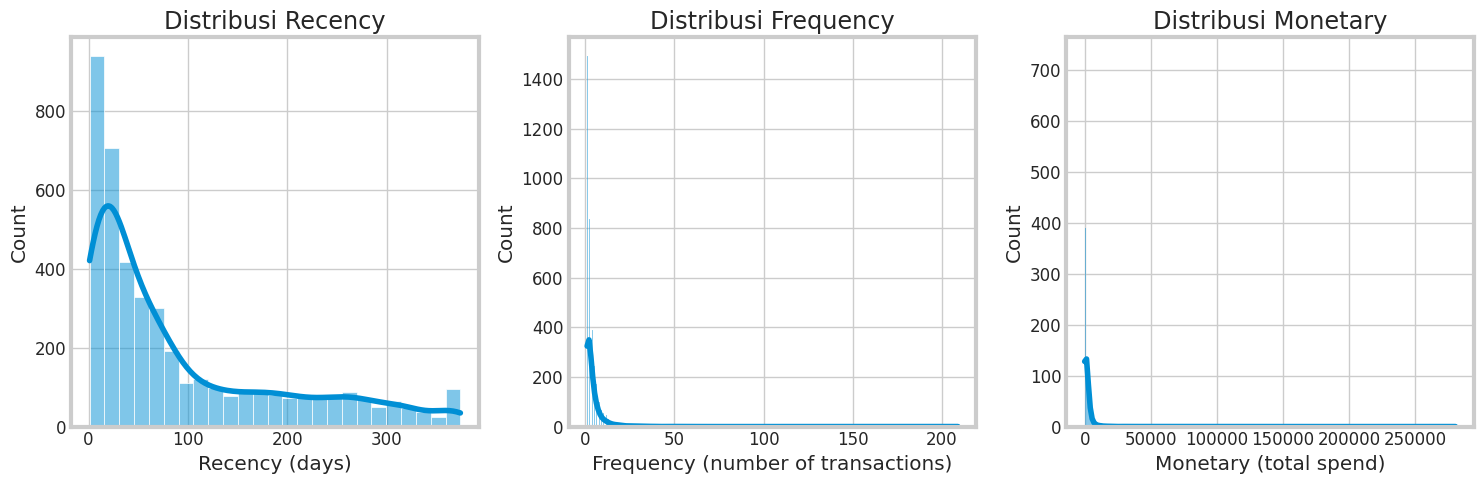

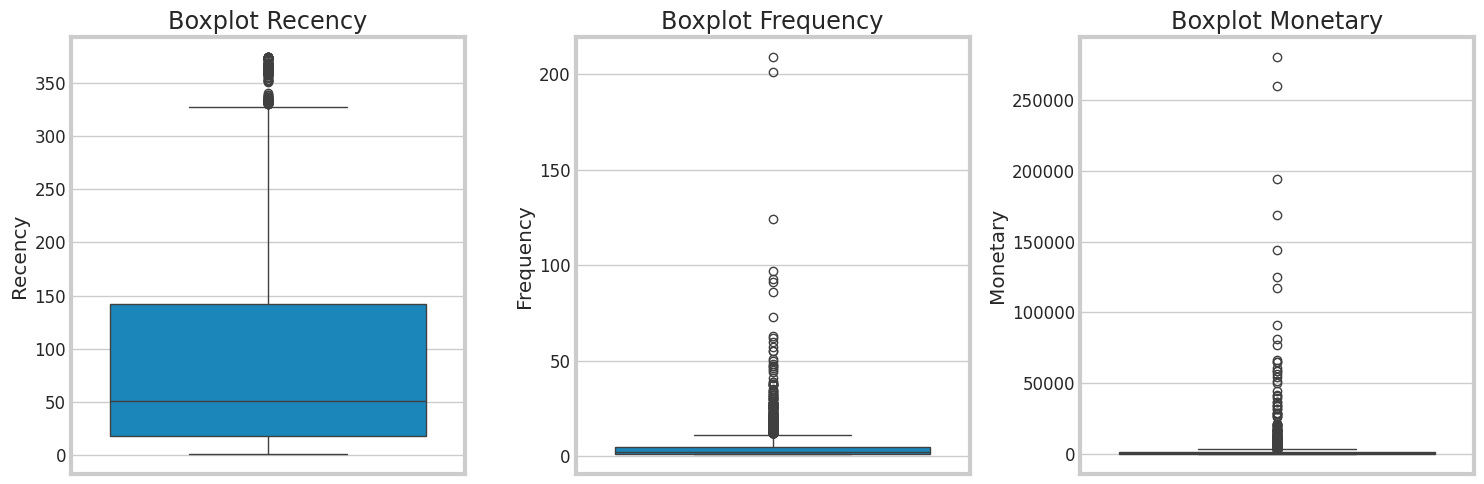

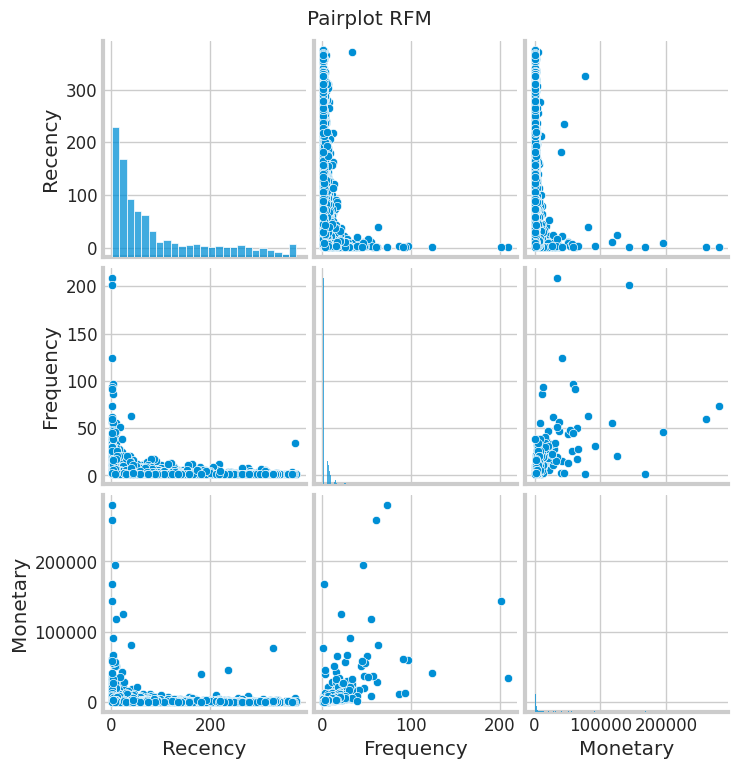

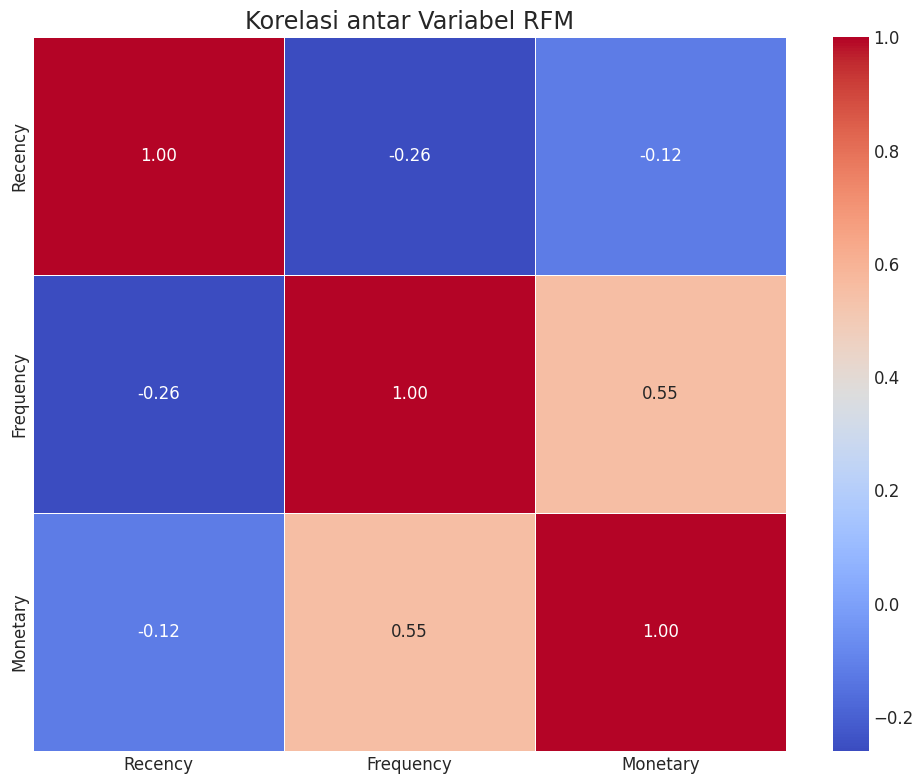

In [76]:
# Visualisasi distribusi RFM
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True)
plt.title('Distribusi Recency')
plt.xlabel('Recency (days)')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Distribusi Frequency')
plt.xlabel('Frequency (number of transactions)')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True)
plt.title('Distribusi Monetary')
plt.xlabel('Monetary (total spend)')

plt.tight_layout()
plt.show()

# Identifikasi outliers dengan box plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=rfm['Recency'])
plt.title('Boxplot Recency')

plt.subplot(1, 3, 2)
sns.boxplot(y=rfm['Frequency'])
plt.title('Boxplot Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(y=rfm['Monetary'])
plt.title('Boxplot Monetary')

plt.tight_layout()
plt.show()

# Visualisasi pairplot untuk melihat hubungan antar variabel
sns.pairplot(rfm)
plt.suptitle('Pairplot RFM', y=1.02)
plt.show()

# Korelasi antar variabel
plt.figure(figsize=(10, 8))
correlation = rfm.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasi antar Variabel RFM')
plt.tight_layout()
plt.show()

### 2.4 Treatment Outliers dan Normalisasi Data

Berdasarkan eksplorasi data, kita perlu menangani outliers dan menormalisasikan data sebelum melakukan clustering.

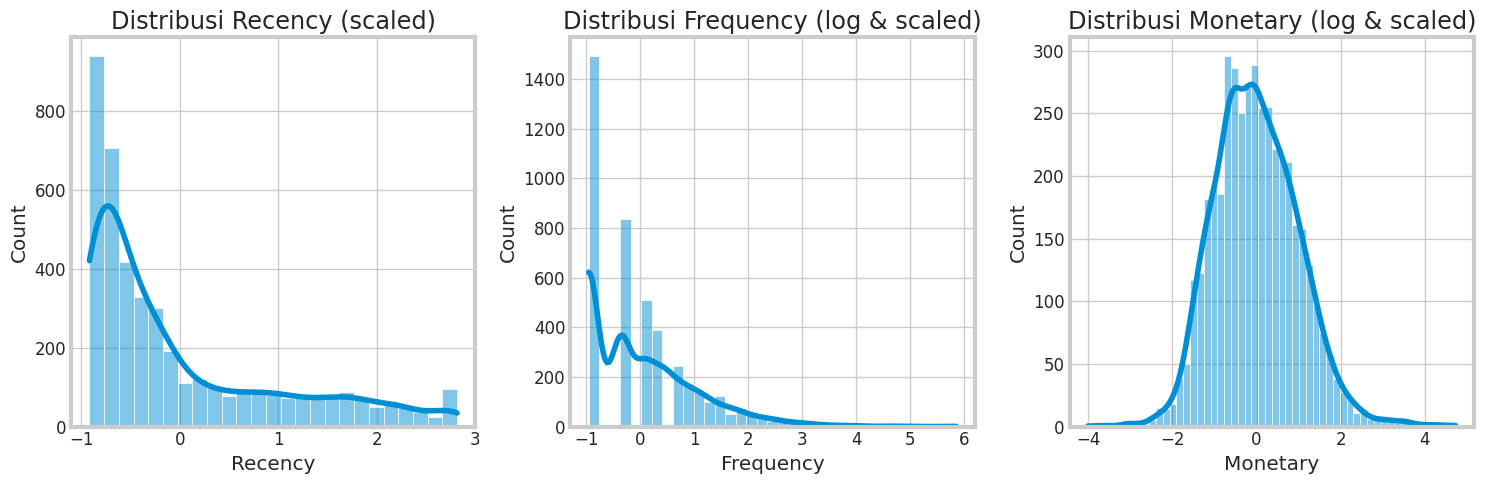

In [77]:
# Log-transform untuk Frequency dan Monetary karena skewed
rfm_log = rfm.copy()
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

# Normalisasi data dengan StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log.columns, index=rfm_log.index)

# Lihat hasil transformasi
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_scaled_df['Recency'], kde=True)
plt.title('Distribusi Recency (scaled)')

plt.subplot(1, 3, 2)
sns.histplot(rfm_scaled_df['Frequency'], kde=True)
plt.title('Distribusi Frequency (log & scaled)')

plt.subplot(1, 3, 3)
sns.histplot(rfm_scaled_df['Monetary'], kde=True)
plt.title('Distribusi Monetary (log & scaled)')

plt.tight_layout()
plt.show()

### 2.5 Principal Component Analysis (PCA) untuk Visualisasi

Untuk memvisualisasikan data multidimensional, kita akan menggunakan PCA untuk mereduksi dimensi menjadi 2D.

Variance explained by PC1: 0.7209
Variance explained by PC2: 0.2156
Total variance explained: 0.9365


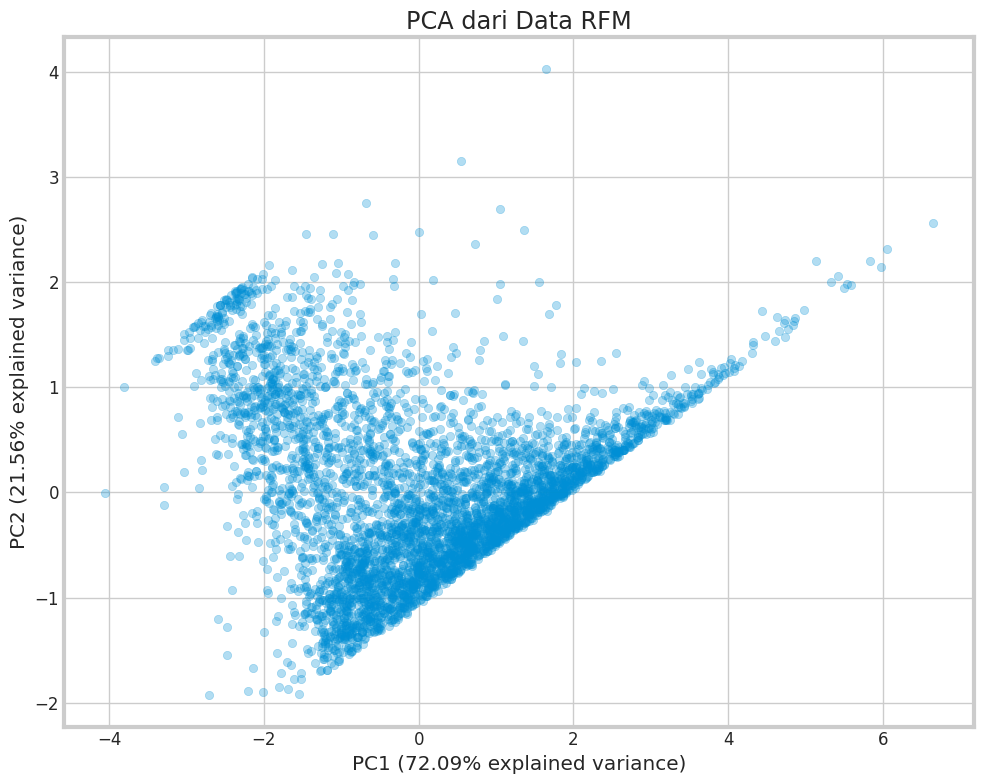

PCA Loading Factors:
                PC1       PC2
Recency   -0.483444  0.874062
Frequency  0.623585  0.305434
Monetary   0.614348  0.377791


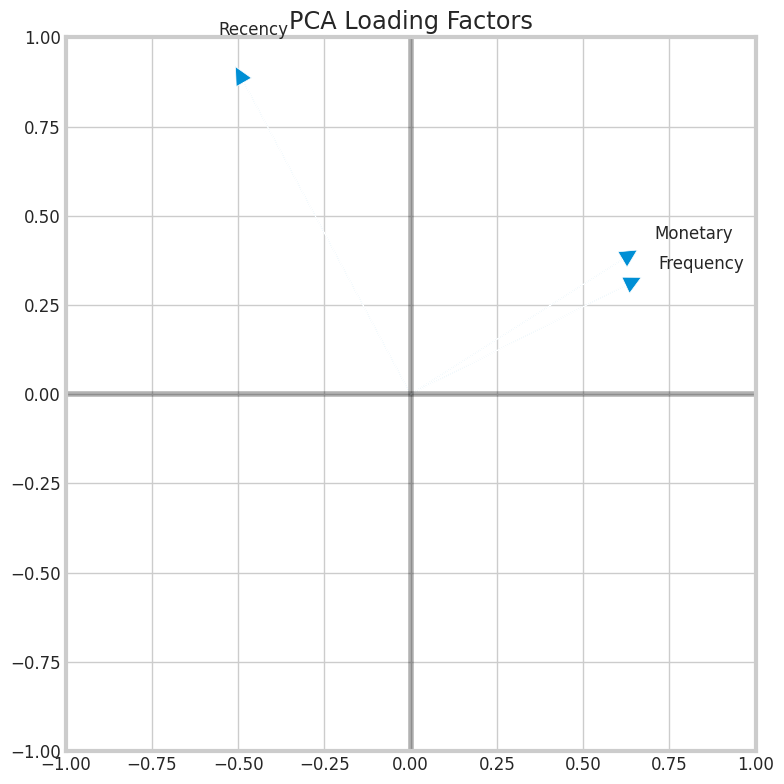

In [78]:
# Terapkan PCA untuk visualisasi
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)
rfm_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=rfm.index)

# Lihat hasil PCA dan variance explained
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Visualisasi PCA
plt.figure(figsize=(10, 8))
plt.scatter(rfm_pca['PC1'], rfm_pca['PC2'], alpha=0.3)
plt.title('PCA dari Data RFM')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisasi loading factors
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=rfm.columns
)
print("PCA Loading Factors:")
print(loadings)

plt.figure(figsize=(8, 8))
for i, feature in enumerate(rfm.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0] * 1.15, loadings.iloc[i, 1] * 1.15, feature, fontsize=12)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.title('PCA Loading Factors')
plt.tight_layout()
plt.show()

## 3. Implementasi Model Clustering

Kita akan mengimplementasikan dua model clustering berbeda:
1. K-Means Clustering
2. Hierarchical Clustering (Agglomerative)

Untuk setiap model, kita akan menentukan jumlah cluster optimal menggunakan Elbow Method dan Silhouette Coefficient.

### 3.1 K-Means Clustering

#### 3.1.1 Penjelasan Matematis K-Means

K-means adalah algoritma clustering yang bertujuan untuk mempartisi $n$ observasi ke dalam $k$ cluster di mana setiap observasi dimiliki oleh cluster dengan mean terdekat. Tujuan utamanya adalah meminimalkan within-cluster sum of squares (WCSS):

$$\min_{S} \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \|\mathbf{x} - oldsymbol{\mu}_i\|^2$$

dimana:
- $S = \{S_1, S_2, ..., S_k\}$ adalah set dari $k$ cluster
- $\mathbf{x}$ adalah titik data dalam cluster $S_i$
- $oldsymbol{\mu}_i$ adalah centroid (mean) dari cluster $S_i$
- $\|\mathbf{x} - oldsymbol{\mu}_i\|^2$ adalah jarak Euclidean kuadrat antara titik data $\mathbf{x}$ dan centroid $oldsymbol{\mu}_i$

Algoritma K-means bekerja sebagai berikut:
1. Inisialisasi $k$ centroid secara acak dari data
2. Tugaskan setiap titik data ke centroid terdekat
3. Hitung ulang centroid sebagai mean dari semua titik yang ditugaskan ke cluster tersebut
4. Ulangi langkah 2-3 hingga konvergen atau mencapai jumlah iterasi maksimum

#### 3.1.2 Elbow Method

Elbow Method adalah pendekatan untuk menentukan jumlah optimal cluster. Metode ini menghitung WCSS untuk berbagai nilai $k$ dan memplot hasilnya. Jumlah cluster optimal adalah titik di mana penambahan cluster tidak lagi secara signifikan mengurangi WCSS, terlihat sebagai "siku" pada grafik.

WCSS didefinisikan sebagai:

$$	ext{WCSS} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \|\mathbf{x} - oldsymbol{\mu}_i\|^2$$

#### 3.1.3 Silhouette Coefficient

Silhouette Coefficient mengukur seberapa baik setiap objek berada dalam cluster-nya sendiri dibandingkan dengan cluster lainnya. Nilai Silhouette Coefficient berkisar dari -1 hingga 1:
- Nilai mendekati 1 menunjukkan objek tergabung dalam cluster yang tepat
- Nilai mendekati 0 menunjukkan objek berada di perbatasan antara dua cluster
- Nilai mendekati -1 menunjukkan objek mungkin ditugaskan ke cluster yang salah

Formula Silhouette Coefficient untuk titik data $i$ adalah:

$$s(i) =
rac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

dimana:
- $a(i)$ adalah jarak rata-rata dari titik $i$ ke semua titik lain dalam cluster yang sama
- $b(i)$ adalah jarak rata-rata minimum dari titik $i$ ke semua titik dalam cluster lain

K=2: WCSS=6872.76, Silhouette=0.4064, Calinski-Harabasz=3874.51, Davies-Bouldin=0.9152
K=3: WCSS=4298.64, Silhouette=0.4156, Calinski-Harabasz=4394.55, Davies-Bouldin=0.8247
K=4: WCSS=3242.05, Silhouette=0.3805, Calinski-Harabasz=4354.41, Davies-Bouldin=0.8570
K=5: WCSS=2760.93, Silhouette=0.3433, Calinski-Harabasz=4022.82, Davies-Bouldin=0.9409
K=6: WCSS=2397.22, Silhouette=0.3307, Calinski-Harabasz=3837.14, Davies-Bouldin=0.9763
K=7: WCSS=2166.67, Silhouette=0.2998, Calinski-Harabasz=3613.89, Davies-Bouldin=1.0259
K=8: WCSS=1960.50, Silhouette=0.3005, Calinski-Harabasz=3487.59, Davies-Bouldin=0.9995
K=9: WCSS=1818.90, Silhouette=0.2813, Calinski-Harabasz=3330.59, Davies-Bouldin=1.0365
K=10: WCSS=1687.86, Silhouette=0.2825, Calinski-Harabasz=3226.98, Davies-Bouldin=1.0203


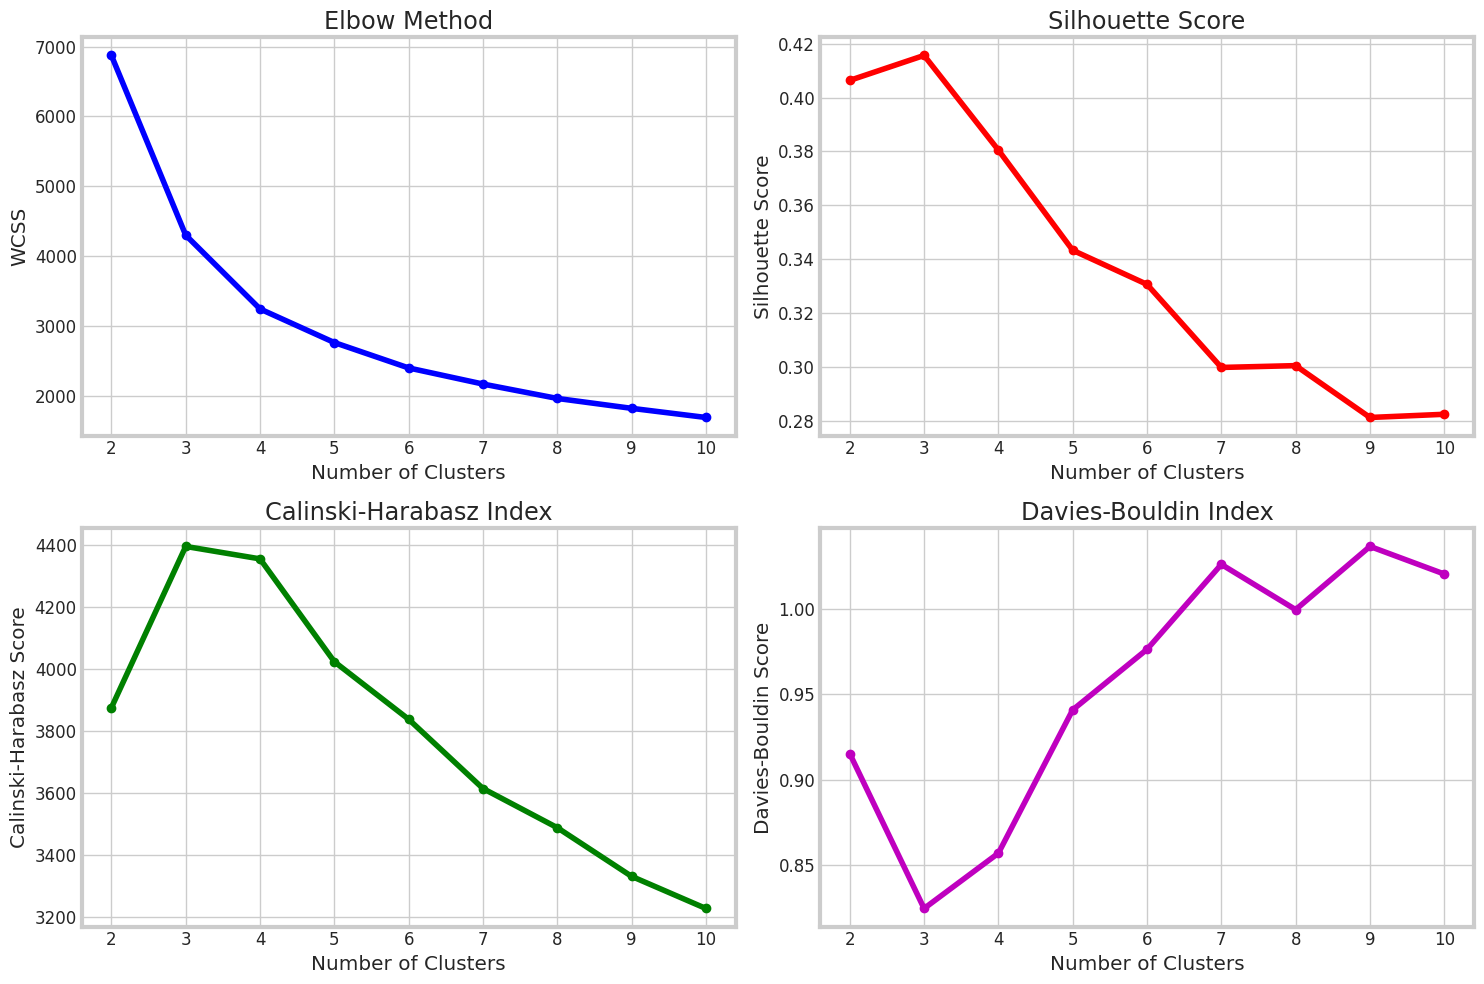

In [79]:
# Definisikan range jumlah cluster yang akan diuji
k_range = range(2, 11)

# Inisialisasi list untuk menyimpan hasil
wcss = []
silhouette_scores = []
calinski_scores = []
davies_scores = []

# Hitung metrik untuk setiap nilai k
for k in k_range:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)

    # Simpan WCSS
    wcss.append(kmeans.inertia_)

    # Hitung Silhouette Score
    labels = kmeans.labels_
    silhouette = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(silhouette)

    # Hitung Calinski-Harabasz Index
    calinski = calinski_harabasz_score(rfm_scaled, labels)
    calinski_scores.append(calinski)

    # Hitung Davies-Bouldin Index
    davies = davies_bouldin_score(rfm_scaled, labels)
    davies_scores.append(davies)

    print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette={silhouette:.4f}, "
          f"Calinski-Harabasz={calinski:.2f}, Davies-Bouldin={davies:.4f}")

# Visualisasi Elbow Method
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(k_range, calinski_scores, 'go-')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(k_range, davies_scores, 'mo-')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

plt.tight_layout()
plt.show()

### 3.1.4 Implementasi K-Means dengan Jumlah Cluster Optimal

Berdasarkan hasil evaluasi dari Elbow Method, Silhouette Coefficient, Calinski-Harabasz Index, dan Davies-Bouldin Index, kita akan memilih jumlah cluster optimal dan menerapkan K-Means.

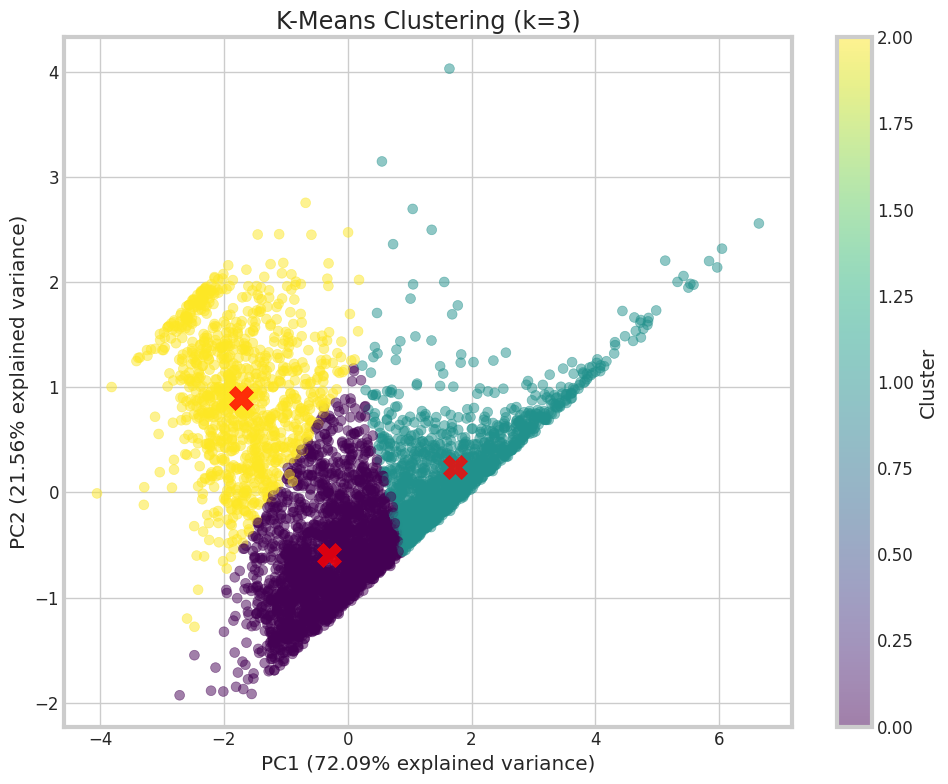

In [80]:
# Berdasarkan hasil analisis metrik, kita pilih jumlah cluster optimal
optimal_k = 3  # Sesuaikan berdasarkan hasil analisis Anda

# Terapkan K-Means dengan jumlah cluster optimal
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(rfm_scaled)

# Tambahkan label cluster ke dataframe RFM
rfm['KMeans_Cluster'] = kmeans_labels
rfm_scaled_df['KMeans_Cluster'] = kmeans_labels
rfm_pca['KMeans_Cluster'] = kmeans_labels

# Visualisasi hasil cluster pada data PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(rfm_pca['PC1'], rfm_pca['PC2'], c=rfm_pca['KMeans_Cluster'],
                      cmap='viridis', alpha=0.5, s=50)

# Tambahkan centroids
centroids_pca = pca.transform(kmeans_optimal.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=300, alpha=0.8, marker='X')

plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.1.5 Analisis Karakteristik Cluster K-Means

Setelah melakukan clustering, kita perlu menganalisis karakteristik dari setiap cluster untuk memahami segmentasi pelanggan.

Statistik per cluster K-Means:
                   Recency                 Frequency              Monetary  \
                      mean  min  max count      mean min  max         mean   
KMeans_Cluster                                                               
0                54.857073    1  191  2036  2.046169   1    7   615.235984   
1                30.100529    1  372  1323  9.829932   1  209  5494.341156   
2               255.271706  107  374   979  1.390194   1    7   398.134924   

                                                
                   min        max          sum  
KMeans_Cluster                                  
0                 6.20    6207.67  1252620.463  
1               621.68  280206.02  7269013.350  
2                 3.75    4959.10   389774.091  


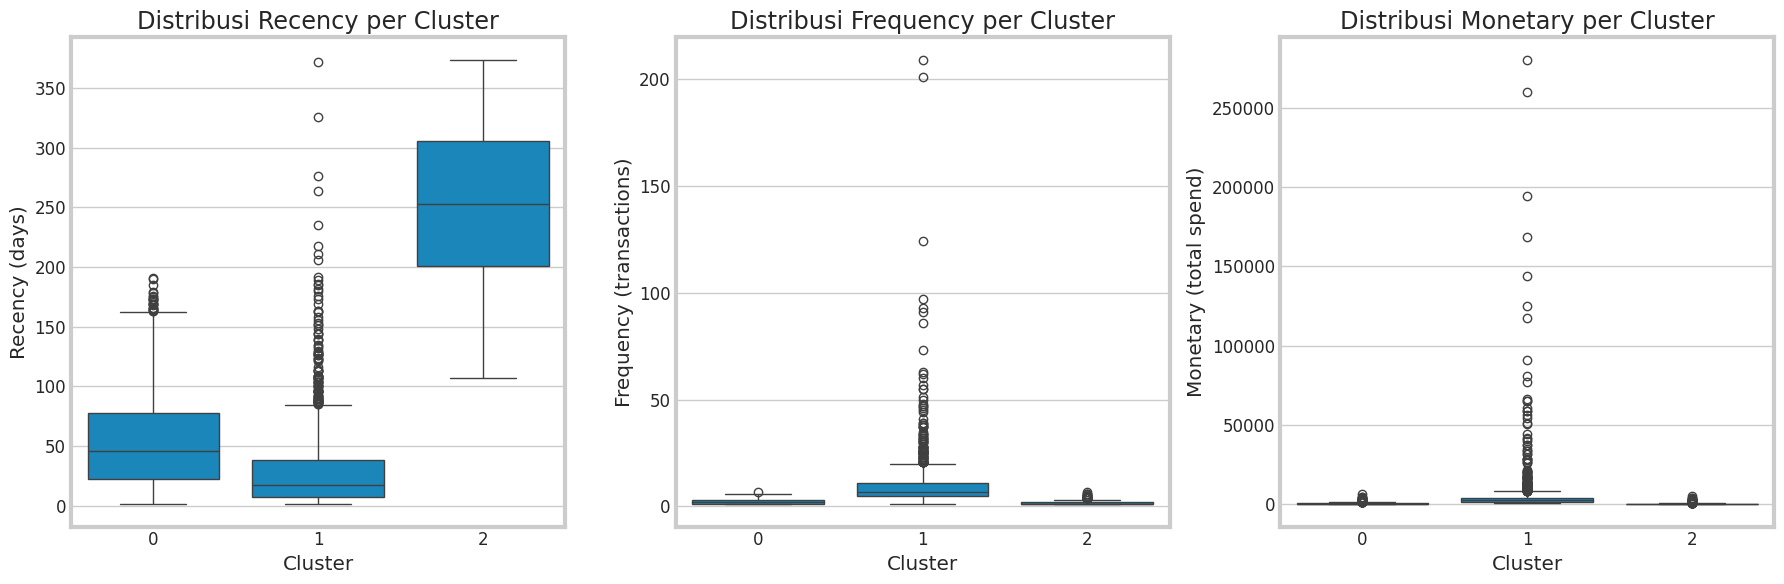

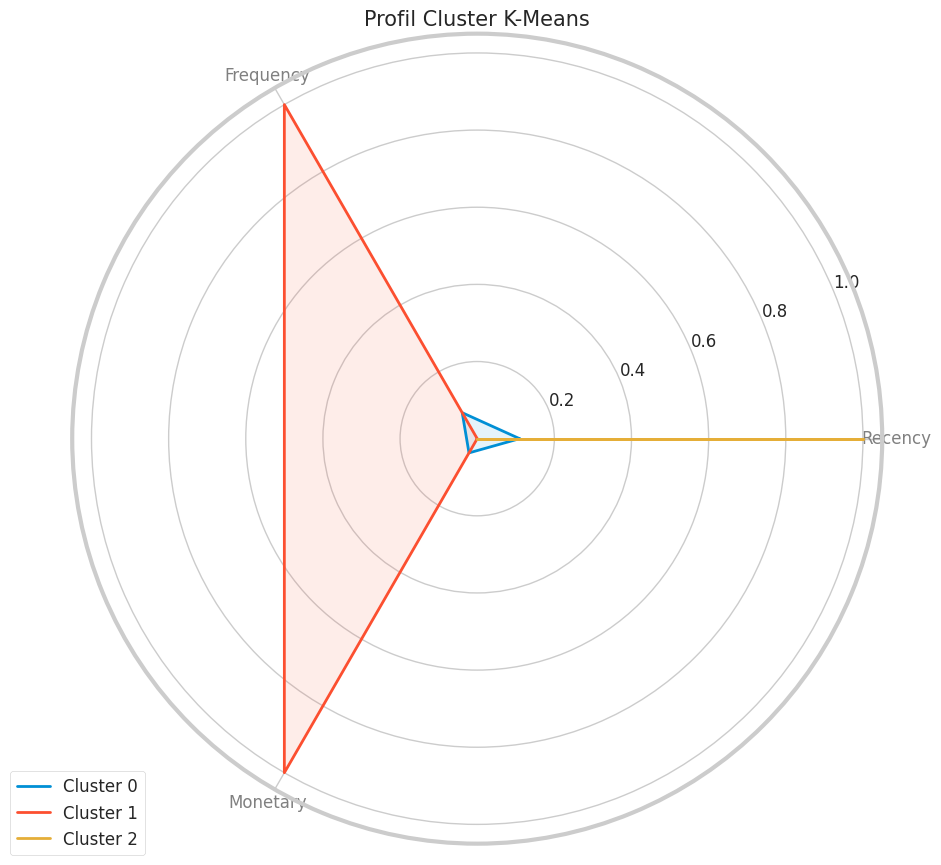

Distribusi Segmentasi Pelanggan:
Customer_Segment
Cluster 0: [Karakteristik Cluster 0]    2036
Cluster 1: [Karakteristik Cluster 1]    1323
Cluster 2: [Karakteristik Cluster 2]     979
Name: count, dtype: int64


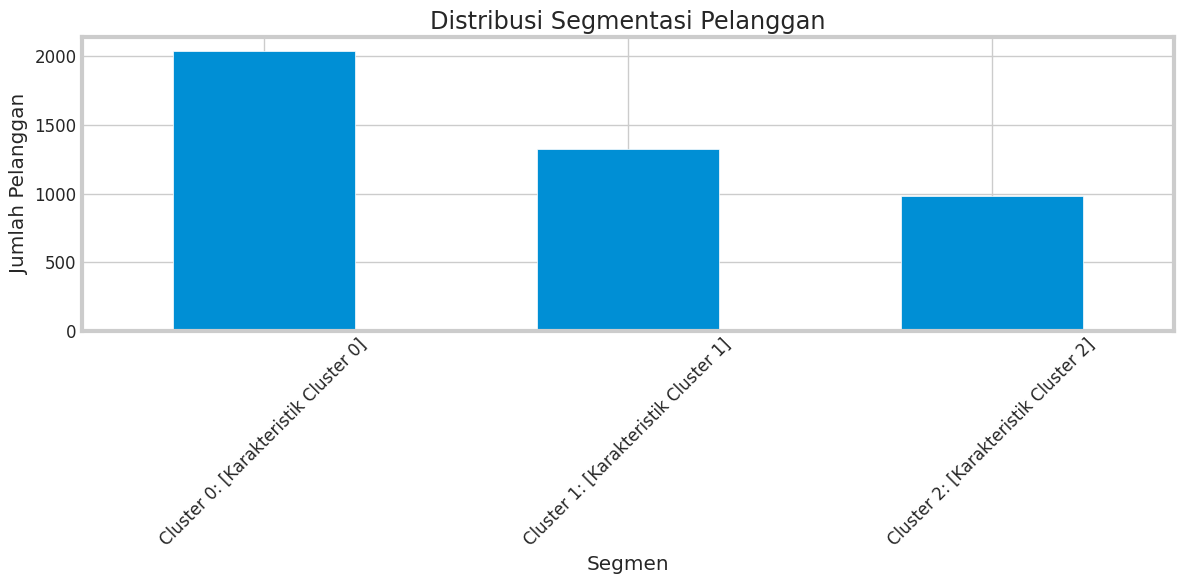

In [81]:
# Analisis statistik per cluster
cluster_stats = rfm.groupby('KMeans_Cluster').agg({
    'Recency': ['mean', 'min', 'max', 'count'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'sum']
})
print("Statistik per cluster K-Means:")
print(cluster_stats)

# Visualisasi distribusi fitur per cluster
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='KMeans_Cluster', y='Recency', data=rfm)
plt.title('Distribusi Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (days)')

plt.subplot(1, 3, 2)
sns.boxplot(x='KMeans_Cluster', y='Frequency', data=rfm)
plt.title('Distribusi Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency (transactions)')

plt.subplot(1, 3, 3)
sns.boxplot(x='KMeans_Cluster', y='Monetary', data=rfm)
plt.title('Distribusi Monetary per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary (total spend)')

plt.tight_layout()
plt.show()

# Visualisasi radar chart untuk perbandingan profil cluster
# Hitung nilai rata-rata yang dinormalisasi untuk setiap fitur per cluster
cluster_means = rfm.groupby('KMeans_Cluster').mean()
normalized_means = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Buat radar chart
categories = normalized_means.columns
N = len(categories)

# Sudut untuk setiap axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Tutup polygon

# Buat figure
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Tambahkan label untuk setiap axis
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Gambar untuk setiap cluster
for i in range(optimal_k):
    values = normalized_means.iloc[i].values.tolist()
    values += values[:1]  # Tutup polygon
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.title('Profil Cluster K-Means', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# Karakterisasi cluster berdasarkan segmentasi pelanggan
# Misalnya: High/Medium/Low untuk setiap dimensi RFM
def segment_label(row):
    if row['KMeans_Cluster'] == 0:
        return "Cluster 0: [Karakteristik Cluster 0]"
    elif row['KMeans_Cluster'] == 1:
        return "Cluster 1: [Karakteristik Cluster 1]"
    elif row['KMeans_Cluster'] == 2:
        return "Cluster 2: [Karakteristik Cluster 2]"
    # Tambahkan kondisi lain jika jumlah cluster > 3
    else:
        return f"Cluster {row['KMeans_Cluster']}"

# Tambahkan label segmentasi ke dataframe
rfm['Customer_Segment'] = rfm.apply(segment_label, axis=1)

# Tampilkan distribusi segmentasi pelanggan
segment_counts = rfm['Customer_Segment'].value_counts()
print("Distribusi Segmentasi Pelanggan:")
print(segment_counts)

plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar')
plt.title('Distribusi Segmentasi Pelanggan')
plt.xlabel('Segmen')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.2 Hierarchical Clustering (Agglomerative)

### 3.2.1 Penjelasan Matematis Hierarchical Clustering

Hierarchical clustering adalah metode clustering yang membangun hirarki cluster. Ada dua pendekatan utama: agglomerative (bottom-up) dan divisive (top-down). Kita akan fokus pada agglomerative clustering.

Agglomerative clustering bekerja dengan langkah-langkah berikut:
1. Mulai dengan setiap titik data sebagai cluster individual
2. Pada setiap langkah, gabungkan dua cluster terdekat menjadi satu cluster baru
3. Lanjutkan sampai semua cluster bergabung menjadi satu cluster

Jarak antar cluster dapat dihitung dengan berbagai metode linkage:

1. **Single Linkage (Minimum Linkage)**:
   $$d(C_i, C_j) = \min_{x \in C_i, y \in C_j} d(x, y)$$

2. **Complete Linkage (Maximum Linkage)**:
   $$d(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)$$

3. **Average Linkage**:
   $$d(C_i, C_j) =
rac{1}{|C_i||C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x, y)$$

4. **Ward's Linkage**: Meminimalkan peningkatan dalam jumlah kuadrat kesalahan (sum of squared errors)
   $$d(C_i, C_j) = \sqrt{
rac{2|C_i||C_j|}{|C_i|+|C_j|}} \|oldsymbol{\mu}_i - oldsymbol{\mu}_j\|$$
   
dimana $C_i$ dan $C_j$ adalah dua cluster, $d(x, y)$ adalah jarak antara titik data $x$ dan $y$, $|C_i|$ adalah jumlah titik dalam cluster $C_i$, dan $oldsymbol{\mu}_i$ adalah centroid cluster $C_i$.

### 3.2.2 Dendrogram

Dendrogram adalah representasi visual dari hirarki cluster. Ini menunjukkan urutan penggabungan cluster dan jarak di mana cluster digabungkan. Tinggi batang menggambarkan jarak antar cluster yang digabungkan.

### 3.2.3 Dunn Index

Dunn Index adalah metrik evaluasi untuk menentukan jumlah cluster optimal dalam hierarchical clustering. Dunn Index didefinisikan sebagai:

$$DI = \min_{1 \leq i < j \leq k} \left\{
rac{\min_{x \in C_i, y \in C_j} d(x, y)}{\max_{1 \leq m \leq k} \{\max_{x, y \in C_m} d(x, y)\}}
ight\}$$

dimana:
- $d(x, y)$ adalah jarak antara titik data $x$ dan $y$
- Pembilang adalah jarak minimum antara titik data dari cluster berbeda (inter-cluster distance)
- Penyebut adalah diameter maksimum dari cluster (intra-cluster distance)

Nilai Dunn Index yang lebih tinggi menunjukkan clustering yang lebih baik (jarak antar cluster tinggi, diameter dalam cluster rendah).

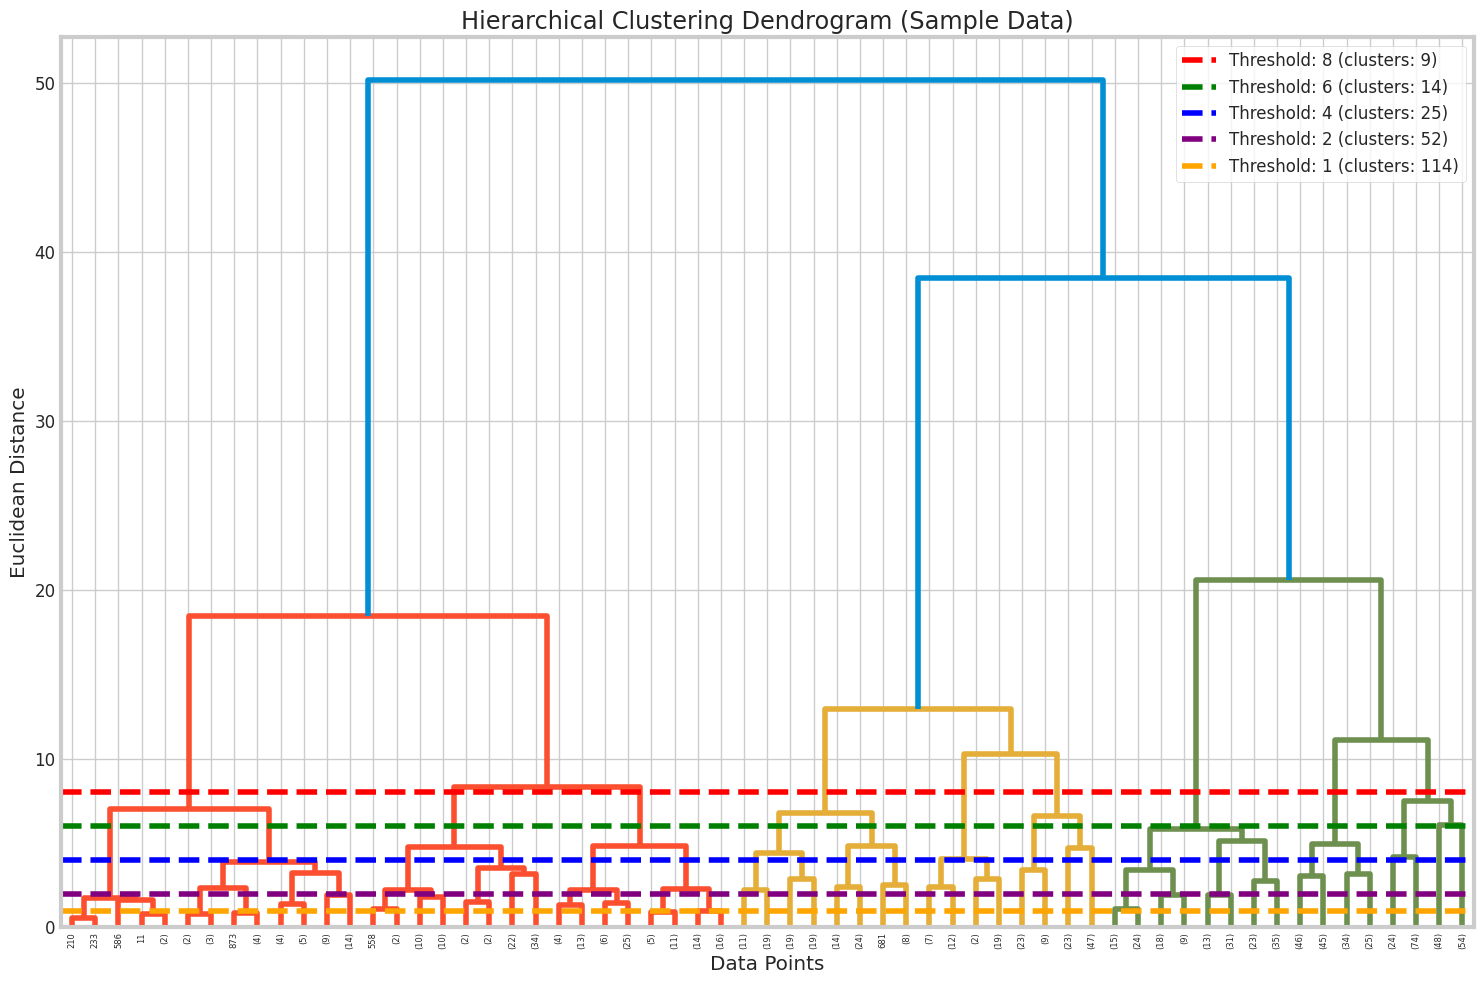

Hierarchical k=2: Silhouette=0.3999, Calinski-Harabasz=3690.98, Davies-Bouldin=0.8919, Dunn Index=0.0072
Hierarchical k=3: Silhouette=0.3959, Calinski-Harabasz=4031.94, Davies-Bouldin=0.8455, Dunn Index=0.0067
Hierarchical k=4: Silhouette=0.3741, Calinski-Harabasz=3623.13, Davies-Bouldin=0.8055, Dunn Index=0.0082
Hierarchical k=5: Silhouette=0.2990, Calinski-Harabasz=3413.69, Davies-Bouldin=0.9815, Dunn Index=0.0082
Hierarchical k=6: Silhouette=0.2761, Calinski-Harabasz=3213.53, Davies-Bouldin=1.0669, Dunn Index=0.0082
Hierarchical k=7: Silhouette=0.2526, Calinski-Harabasz=3113.04, Davies-Bouldin=1.1322, Dunn Index=0.0084
Hierarchical k=8: Silhouette=0.2398, Calinski-Harabasz=2891.68, Davies-Bouldin=1.1071, Dunn Index=0.0084
Hierarchical k=9: Silhouette=0.2274, Calinski-Harabasz=2744.32, Davies-Bouldin=1.1823, Dunn Index=0.0062
Hierarchical k=10: Silhouette=0.2333, Calinski-Harabasz=2636.23, Davies-Bouldin=1.1577, Dunn Index=0.0059


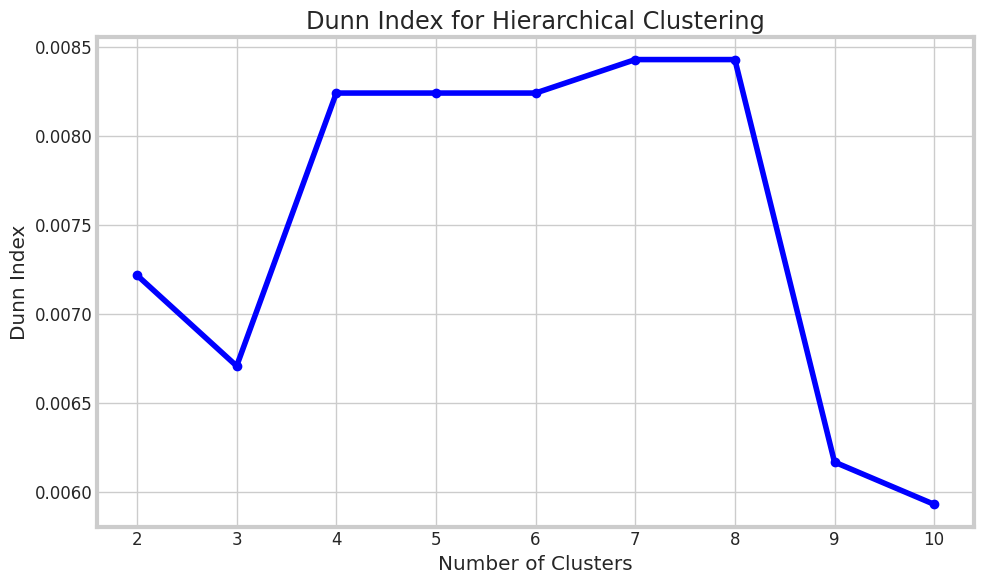

Jumlah cluster optimal berdasarkan Dunn Index: 7


In [82]:
# Hitung jarak antar titik data
dist_matrix = pairwise_distances(rfm_scaled, metric='euclidean')

# Visualisasi Dendrogram untuk menentukan jumlah cluster
plt.figure(figsize=(15, 10))

# Terapkan Hierarchical Clustering
# Catatan: Karena dendrogram dengan semua data bisa sangat besar,
# kita akan menggunakan sampel data jika terlalu banyak observasi
if len(rfm_scaled) > 1000:
    # Ambil sampel acak 1000 observasi
    np.random.seed(42)
    sample_idx = np.random.choice(range(len(rfm_scaled)), size=1000, replace=False)
    sample_data = rfm_scaled[sample_idx]

    # Hitung linkage matrix
    link = linkage(sample_data, method='ward')

    plt.title('Hierarchical Clustering Dendrogram (Sample Data)')
else:
    # Gunakan semua data
    link = linkage(rfm_scaled, method='ward')
    plt.title('Hierarchical Clustering Dendrogram')

# Plot dendrogram
dendrogram(link, truncate_mode='level', p=5)
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')

# Tambahkan garis horizontal untuk menunjukkan clustering potensial
colors = ['red', 'green', 'blue', 'purple', 'orange']
thresholds = [8, 6, 4, 2, 1]  # Sesuaikan threshold berdasarkan dendrogram

for i, threshold in enumerate(thresholds):
    plt.axhline(y=threshold, c=colors[i], linestyle='--',
                label=f'Threshold: {threshold} (clusters: {len(np.unique(fcluster(link, threshold, criterion="distance")))})')

plt.legend()
plt.tight_layout()
plt.show()

# Implementasi Dunn Index
def dunn_index(X, labels):
    """Calculate Dunn Index for cluster evaluation"""
    unique_labels = np.unique(labels)

    # Calculate minimum inter-cluster distance
    min_inter_cluster_dist = float('inf')
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]

            # Calculate pairwise distances between clusters
            dists = pairwise_distances(cluster_i, cluster_j, metric='euclidean')
            min_dist = np.min(dists)

            if min_dist < min_inter_cluster_dist:
                min_inter_cluster_dist = min_dist

    # Calculate maximum intra-cluster distance (cluster diameter)
    max_intra_cluster_dist = 0
    for i in range(len(unique_labels)):
        cluster_i = X[labels == unique_labels[i]]
        if len(cluster_i) > 1:  # Skip clusters with only one point
            dists = pairwise_distances(cluster_i, metric='euclidean')
            max_dist = np.max(dists)

            if max_dist > max_intra_cluster_dist:
                max_intra_cluster_dist = max_dist

    if max_intra_cluster_dist == 0:  # Avoid division by zero
        return 0

    return min_inter_cluster_dist / max_intra_cluster_dist

# Evaluasi berbagai jumlah cluster dengan metrik tambahan
k_range = range(2, 11)
dunn_scores = []

for k in k_range:
    # Fit Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg_clustering.fit_predict(rfm_scaled)

    # Hitung Dunn Index
    dunn = dunn_index(rfm_scaled, labels)
    dunn_scores.append(dunn)

    # Hitung metrik lain yang sudah dihitung sebelumnya
    silhouette = silhouette_score(rfm_scaled, labels)
    calinski = calinski_harabasz_score(rfm_scaled, labels)
    davies = davies_bouldin_score(rfm_scaled, labels)

    print(f"Hierarchical k={k}: "
          f"Silhouette={silhouette:.4f}, Calinski-Harabasz={calinski:.2f}, "
          f"Davies-Bouldin={davies:.4f}, Dunn Index={dunn:.4f}")

# Visualisasi Dunn Index
plt.figure(figsize=(10, 6))
plt.plot(k_range, dunn_scores, 'bo-')
plt.title('Dunn Index for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.grid(True)
plt.tight_layout()
plt.show()

# Berdasarkan evaluasi, tentukan jumlah cluster optimal untuk Hierarchical Clustering
optimal_k_hierarchical = k_range[np.argmax(dunn_scores)]  # Maksimalisasi Dunn Index
print(f"Jumlah cluster optimal berdasarkan Dunn Index: {optimal_k_hierarchical}")

### 3.2.4 Implementasi Hierarchical Clustering dengan Jumlah Cluster Optimal

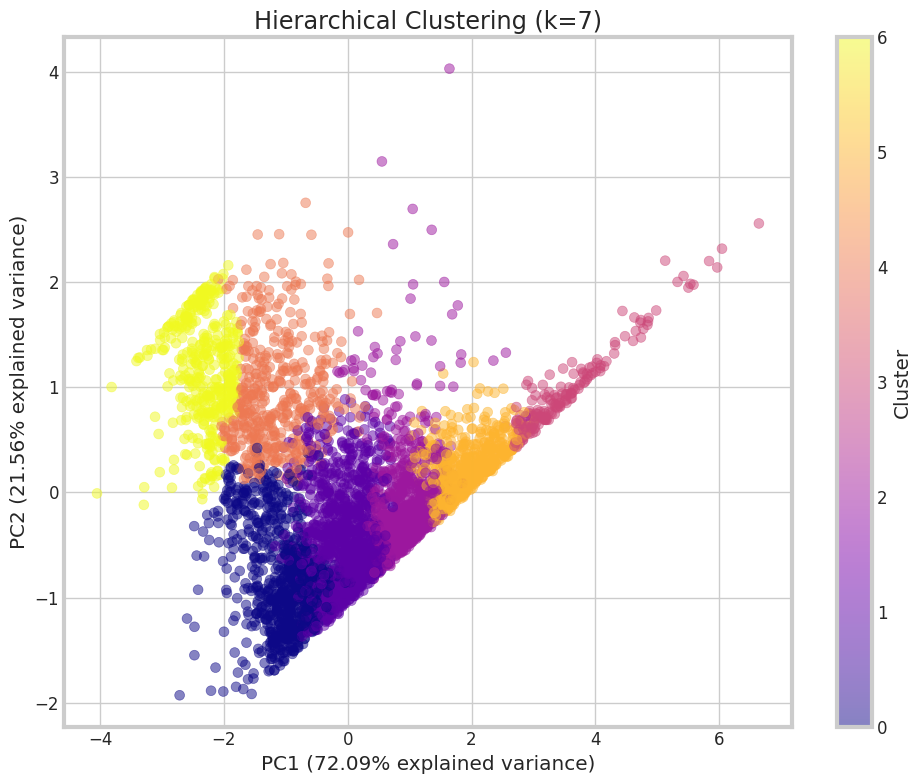

In [83]:
# Terapkan Agglomerative Clustering dengan jumlah cluster optimal
agg_optimal = AgglomerativeClustering(n_clusters=optimal_k_hierarchical, linkage='ward')
hierarchical_labels = agg_optimal.fit_predict(rfm_scaled)

# Tambahkan label cluster ke dataframe RFM
rfm['Hierarchical_Cluster'] = hierarchical_labels
rfm_scaled_df['Hierarchical_Cluster'] = hierarchical_labels
rfm_pca['Hierarchical_Cluster'] = hierarchical_labels

# Visualisasi hasil cluster pada data PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(rfm_pca['PC1'], rfm_pca['PC2'], c=rfm_pca['Hierarchical_Cluster'],
                      cmap='plasma', alpha=0.5, s=50)

plt.title(f'Hierarchical Clustering (k={optimal_k_hierarchical})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.2.5 Analisis Karakteristik Cluster Hierarchical

Statistik per cluster Hierarchical:
                         Recency                  Frequency           \
                            mean  min  max count       mean min  max   
Hierarchical_Cluster                                                   
0                      71.960621    1  206   838   1.072792   1    6   
1                      58.318471    1  188  1099   2.364877   1    5   
2                      40.531677    1  372   805   4.643478   1   34   
3                       8.590062    1   43   161  29.757764  10  209   
4                     229.420824  137  373   461   1.861171   1    7   
5                      20.500000    1  114   562   9.302491   5   22   
6                     305.177184  204  374   412   1.016990   1    2   

                          Monetary                                   
                              mean      min        max          sum  
Hierarchical_Cluster                                                 
0                       270.62297

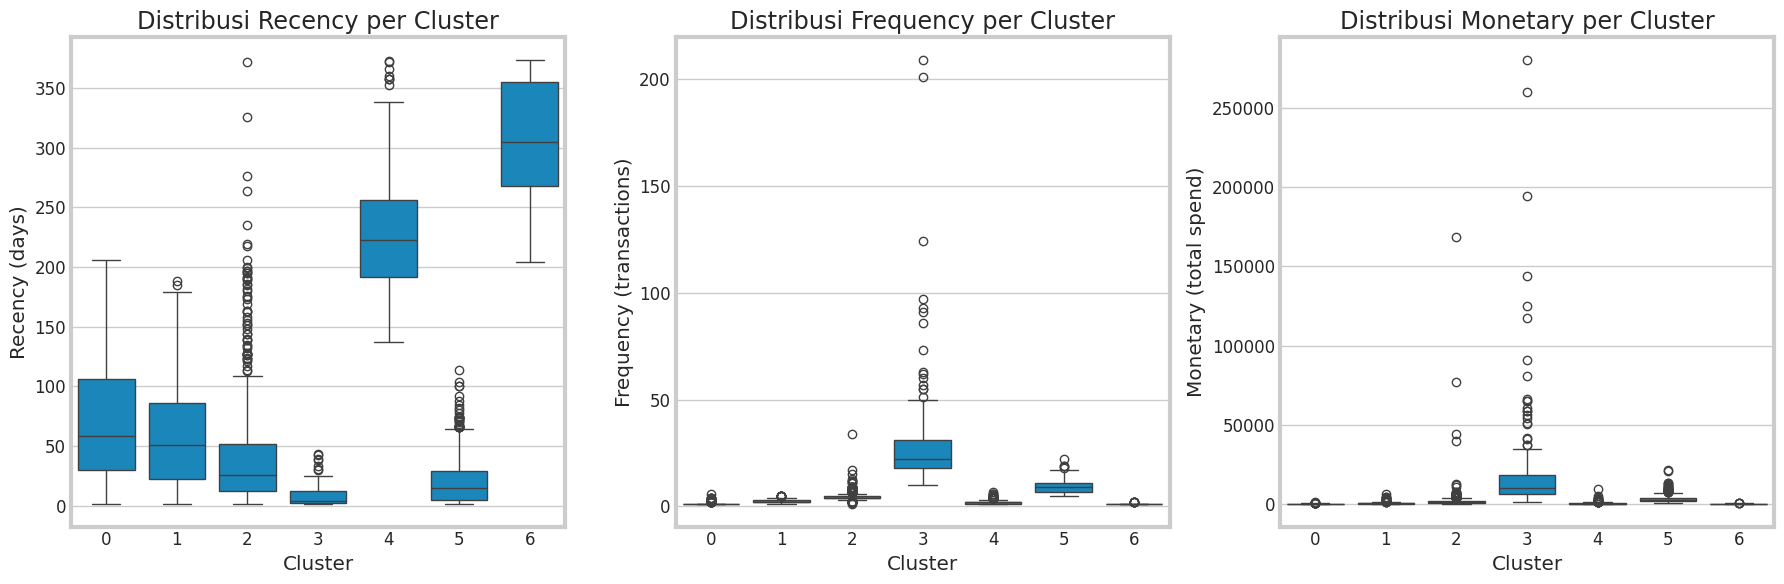

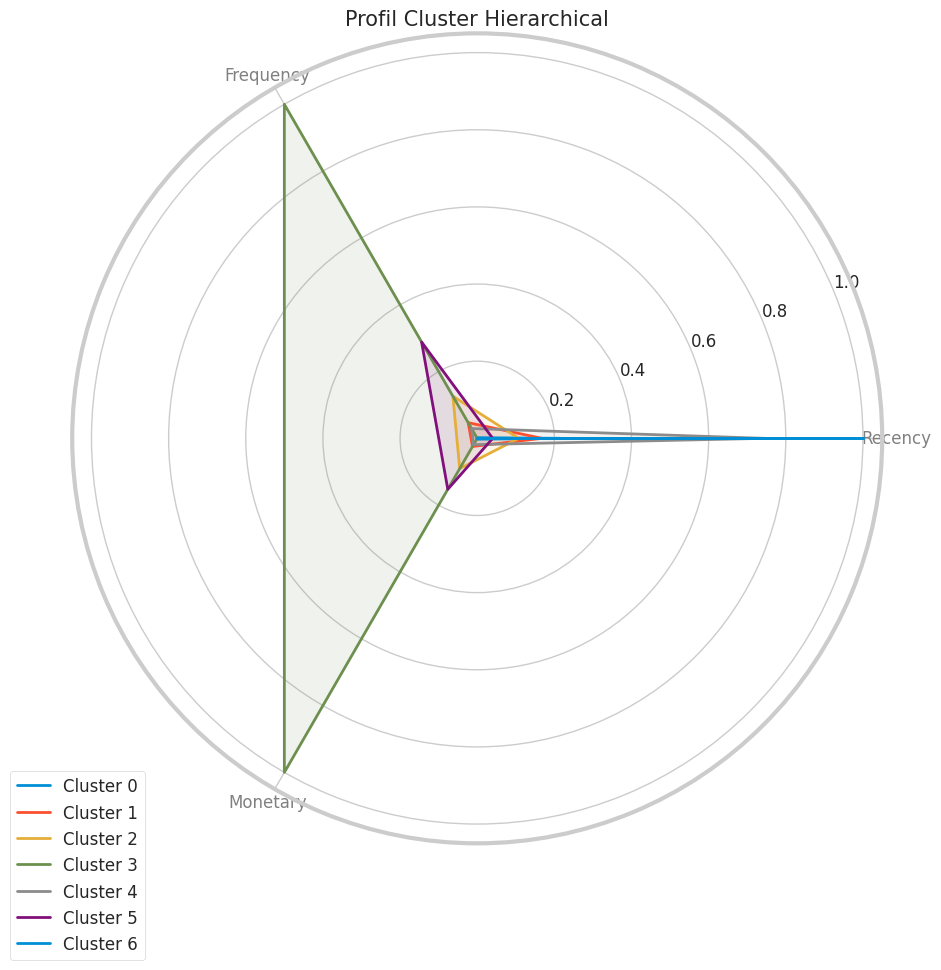

In [84]:
# Analisis statistik per cluster
cluster_stats_hierarchical = rfm.groupby('Hierarchical_Cluster').agg({
    'Recency': ['mean', 'min', 'max', 'count'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'sum']
})
print("Statistik per cluster Hierarchical:")
print(cluster_stats_hierarchical)

# Visualisasi distribusi fitur per cluster
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Hierarchical_Cluster', y='Recency', data=rfm)
plt.title('Distribusi Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (days)')

plt.subplot(1, 3, 2)
sns.boxplot(x='Hierarchical_Cluster', y='Frequency', data=rfm)
plt.title('Distribusi Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency (transactions)')

plt.subplot(1, 3, 3)
sns.boxplot(x='Hierarchical_Cluster', y='Monetary', data=rfm)
plt.title('Distribusi Monetary per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary (total spend)')

plt.tight_layout()
plt.show()

# Visualisasi radar chart untuk perbandingan profil cluster
# Hitung nilai rata-rata yang dinormalisasi untuk setiap fitur per cluster
cluster_means_hierarchical = rfm.groupby('Hierarchical_Cluster').mean(numeric_only=True)
normalized_means_hierarchical = (cluster_means_hierarchical - cluster_means_hierarchical.min()) / \
                               (cluster_means_hierarchical.max() - cluster_means_hierarchical.min())

# Buat radar chart
categories = ['Recency', 'Frequency', 'Monetary']
N = len(categories)

# Sudut untuk setiap axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Tutup polygon

# Buat figure
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Tambahkan label untuk setiap axis
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Gambar untuk setiap cluster
for i in range(optimal_k_hierarchical):
    values = normalized_means_hierarchical.iloc[i][categories].values.tolist()
    values += values[:1]  # Tutup polygon
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.title('Profil Cluster Hierarchical', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

## 4. Perbandingan Metrik Evaluasi

### 4.1 Penjelasan Matematis Metrik Evaluasi Clustering

#### 4.1.1 Elbow Method (Within-Cluster Sum of Squares/WCSS)

WCSS mengukur kompaktifikasi (compactness) dari cluster, didefinisikan sebagai jumlah kuadrat jarak dari setiap titik data ke centroid cluster-nya:

$$	ext{WCSS} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - oldsymbol{\mu}_i\|^2$$

di mana $C_i$ adalah cluster ke-$i$, $\mathbf{x}$ adalah titik data dalam cluster $C_i$, dan $oldsymbol{\mu}_i$ adalah centroid dari cluster $C_i$.

Nilai WCSS menurun saat jumlah cluster meningkat. Jumlah cluster optimal dapat dilihat pada "siku" (elbow) dalam plot WCSS vs. jumlah cluster.

#### 4.1.2 Silhouette Coefficient

Silhouette Coefficient mengukur seberapa baik titik data dikelompokkan dalam cluster, dengan mempertimbangkan jarak intra-cluster (kohesi) dan jarak inter-cluster (separasi):

$$s(i) =
rac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$

di mana:
- $a(i)$ adalah jarak rata-rata titik $i$ ke semua titik lain dalam cluster yang sama (kohesi)
- $b(i)$ adalah jarak rata-rata minimum dari titik $i$ ke semua titik dalam cluster lain terdekat (separasi)

Silhouette Coefficient untuk dataset adalah rata-rata dari Silhouette Coefficient untuk semua titik data:

$$	ext{Silhouette} =
rac{1}{n} \sum_{i=1}^{n} s(i)$$

Nilai berkisar dari -1 hingga 1, di mana:
Nilai berkisar dari -1 hingga 1, di mana:
- Nilai mendekati 1 berarti titik data jauh dari cluster terdekat (clustering baik)
- Nilai mendekati 0 berarti titik data berada di perbatasan antara dua cluster
- Nilai mendekati -1 berarti titik data mungkin ditempatkan di cluster yang salah

#### 4.1.3 Calinski-Harabasz Index (Variance Ratio Criterion)

Calinski-Harabasz Index mengukur rasio dari dispersi antar-cluster dan dispersi intra-cluster:

$$	ext{CH} =
rac{	ext{TR}_B}{	ext{TR}_W} 	imes
rac{N - k}{k - 1}$$

di mana:
- $	ext{TR}_B$ adalah trace dari matriks dispersi antar-cluster: $	ext{TR}_B = \sum_{i=1}^{k} n_i \|oldsymbol{\mu}_i - oldsymbol{\mu}\|^2$
- $	ext{TR}_W$ adalah trace dari matriks dispersi intra-cluster: $	ext{TR}_W = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - oldsymbol{\mu}_i\|^2$
- $N$ adalah jumlah total titik data
- $k$ adalah jumlah cluster
- $n_i$ adalah jumlah titik dalam cluster $C_i$
- $oldsymbol{\mu}_i$ adalah centroid cluster $C_i$
- $oldsymbol{\mu}$ adalah centroid seluruh dataset

Nilai CH yang lebih tinggi menunjukkan cluster yang lebih terdefinisi dengan baik (cluster yang kompak dan terpisah dengan baik).

#### 4.1.4 Davies-Bouldin Index

Davies-Bouldin Index mengukur jarak rata-rata antara cluster relatif terhadap ukuran cluster:

$$	ext{DB} =
rac{1}{k} \sum_{i=1}^{k} \max_{j
eq i} R_{ij}$$

di mana:
- $R_{ij} =
rac{s_i + s_j}{d_{ij}}$ adalah rasio kesamaan antara cluster $i$ dan $j$
- $s_i$ adalah ukuran rata-rata cluster $i$: $s_i =
rac{1}{|C_i|} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - oldsymbol{\mu}_i\|$
- $d_{ij}$ adalah jarak antara centroid cluster $i$ dan $j$: $d_{ij} = \|oldsymbol{\mu}_i - oldsymbol{\mu}_j\|$

Nilai DB yang lebih rendah menunjukkan cluster yang lebih terpisah dan kompak (clustering yang lebih baik).

#### 4.1.5 Dunn Index

Dunn Index fokus pada jarak minimum antar-cluster relatif terhadap diameter maksimum intra-cluster:

$$	ext{DI} =
rac{\min_{i
eq j} d(C_i, C_j)}{\max_{k} 	ext{diam}(C_k)}$$

di mana:
- $d(C_i, C_j)$ adalah jarak antara cluster $C_i$ dan $C_j$, biasanya didefinisikan sebagai jarak minimum antara titik apa pun dalam $C_i$ dan titik apa pun dalam $C_j$
- $	ext{diam}(C_k)$ adalah diameter cluster $C_k$, yang merupakan jarak maksimum antara dua titik dalam cluster

Nilai DI yang lebih tinggi menunjukkan clustering yang lebih baik, dengan cluster yang lebih terpisah dan kompak.

### 4.2 Perbandingan Hasil Evaluasi

Perbandingan Metrik Evaluasi:
    K  K-Means: Silhouette  K-Means: Calinski-Harabasz  \
0   2             0.406390                 3874.507025   
1   3             0.415646                 4394.545846   
2   4             0.380497                 4354.407729   
3   5             0.343331                 4022.815872   
4   6             0.330665                 3837.140923   
5   7             0.299834                 3613.894666   
6   8             0.300510                 3487.586638   
7   9             0.281262                 3330.591085   
8  10             0.282450                 3226.977073   

   K-Means: Davies-Bouldin  Hierarchical: Dunn Index  
0                 0.915233                  0.007218  
1                 0.824667                  0.006707  
2                 0.857012                  0.008243  
3                 0.940857                  0.008243  
4                 0.976253                  0.008243  
5                 1.025949                  0.008432  
6   

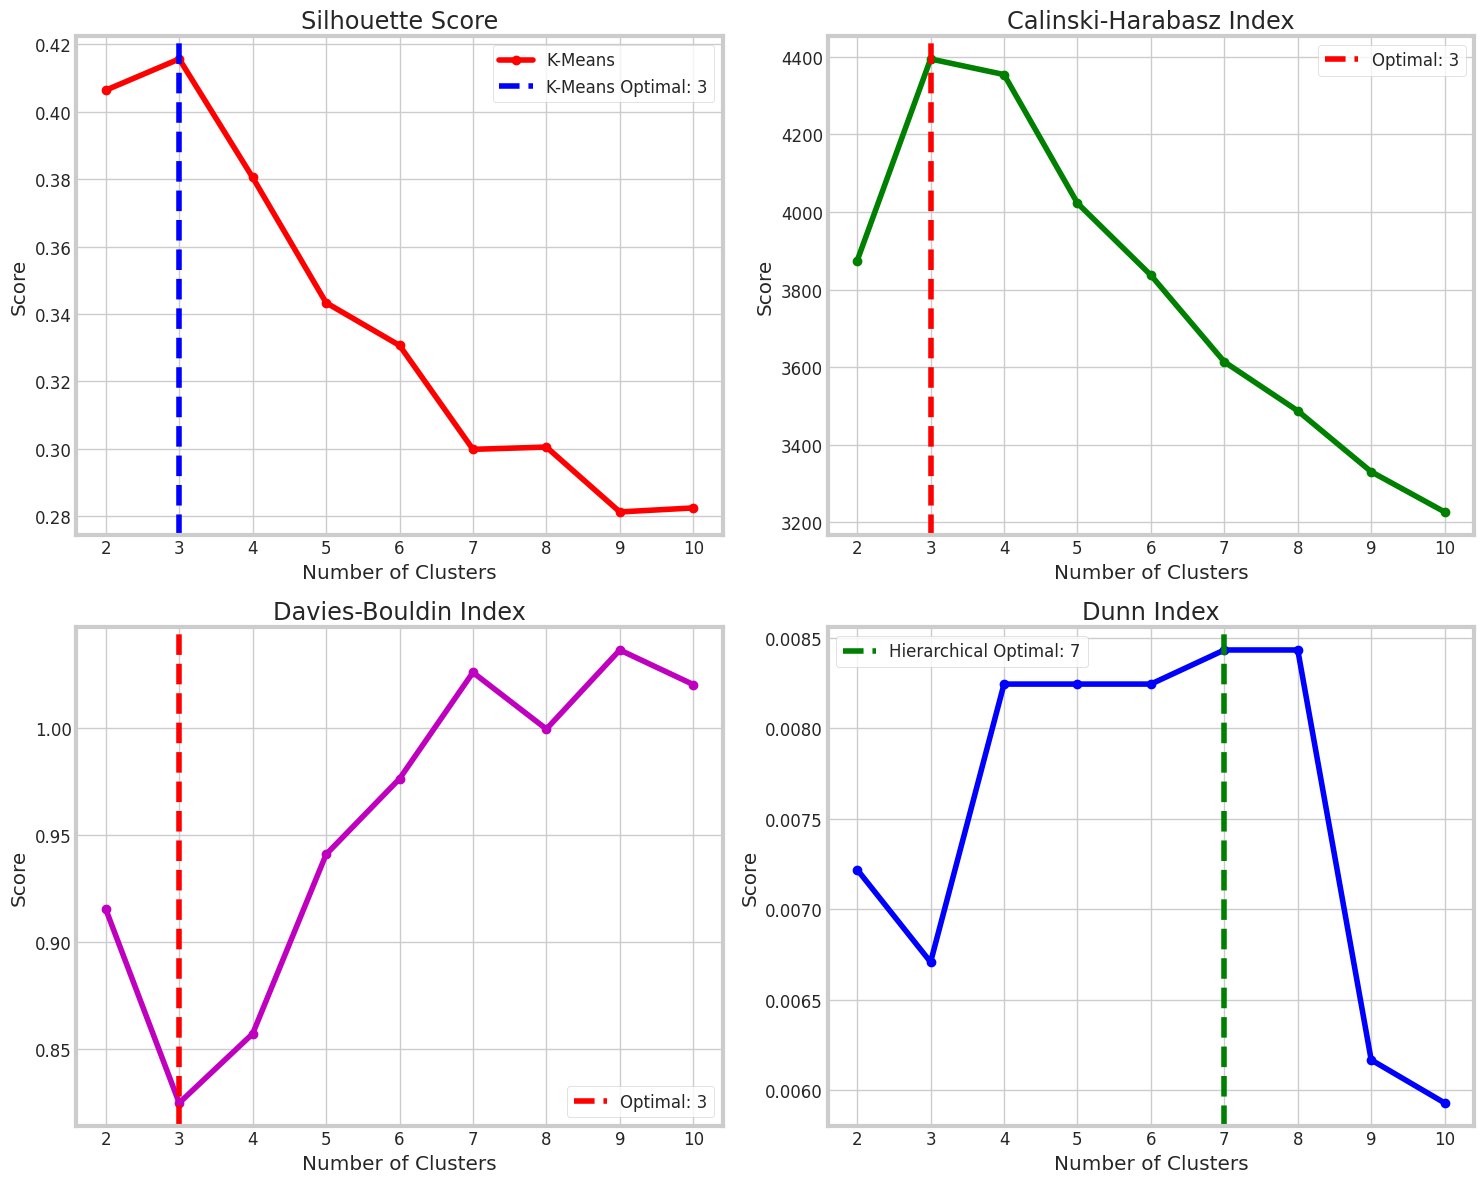

In [85]:
# Membuat tabel perbandingan metrik untuk K-Means dan Hierarchical Clustering
comparison_metrics = pd.DataFrame({
    'K': list(k_range),
    'K-Means: Silhouette': silhouette_scores,
    'K-Means: Calinski-Harabasz': calinski_scores,
    'K-Means: Davies-Bouldin': davies_scores,
    'Hierarchical: Dunn Index': dunn_scores
})

print("Perbandingan Metrik Evaluasi:")
print(comparison_metrics)

# Visualisasi perbandingan metrik
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette Score
axes[0, 0].plot(k_range, silhouette_scores, 'ro-', label='K-Means')
axes[0, 0].set_title('Silhouette Score')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Score')
axes[0, 0].grid(True)
axes[0, 0].axvline(x=optimal_k, color='blue', linestyle='--', label=f'K-Means Optimal: {optimal_k}')
axes[0, 0].legend()

# Calinski-Harabasz Index
axes[0, 1].plot(k_range, calinski_scores, 'go-')
axes[0, 1].set_title('Calinski-Harabasz Index')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Score')
axes[0, 1].grid(True)
axes[0, 1].axvline(x=k_range[np.argmax(calinski_scores)], color='red', linestyle='--',
                  label=f'Optimal: {k_range[np.argmax(calinski_scores)]}')
axes[0, 1].legend()

# Davies-Bouldin Index
axes[1, 0].plot(k_range, davies_scores, 'mo-')
axes[1, 0].set_title('Davies-Bouldin Index')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Score')
axes[1, 0].grid(True)
axes[1, 0].axvline(x=k_range[np.argmin(davies_scores)], color='red', linestyle='--',
                  label=f'Optimal: {k_range[np.argmin(davies_scores)]}')
axes[1, 0].legend()

# Dunn Index
axes[1, 1].plot(k_range, dunn_scores, 'bo-')
axes[1, 1].set_title('Dunn Index')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True)
axes[1, 1].axvline(x=optimal_k_hierarchical, color='green', linestyle='--',
                  label=f'Hierarchical Optimal: {optimal_k_hierarchical}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 4.3 Analisis Perbandingan Cluster antara K-Means dan Hierarchical Clustering

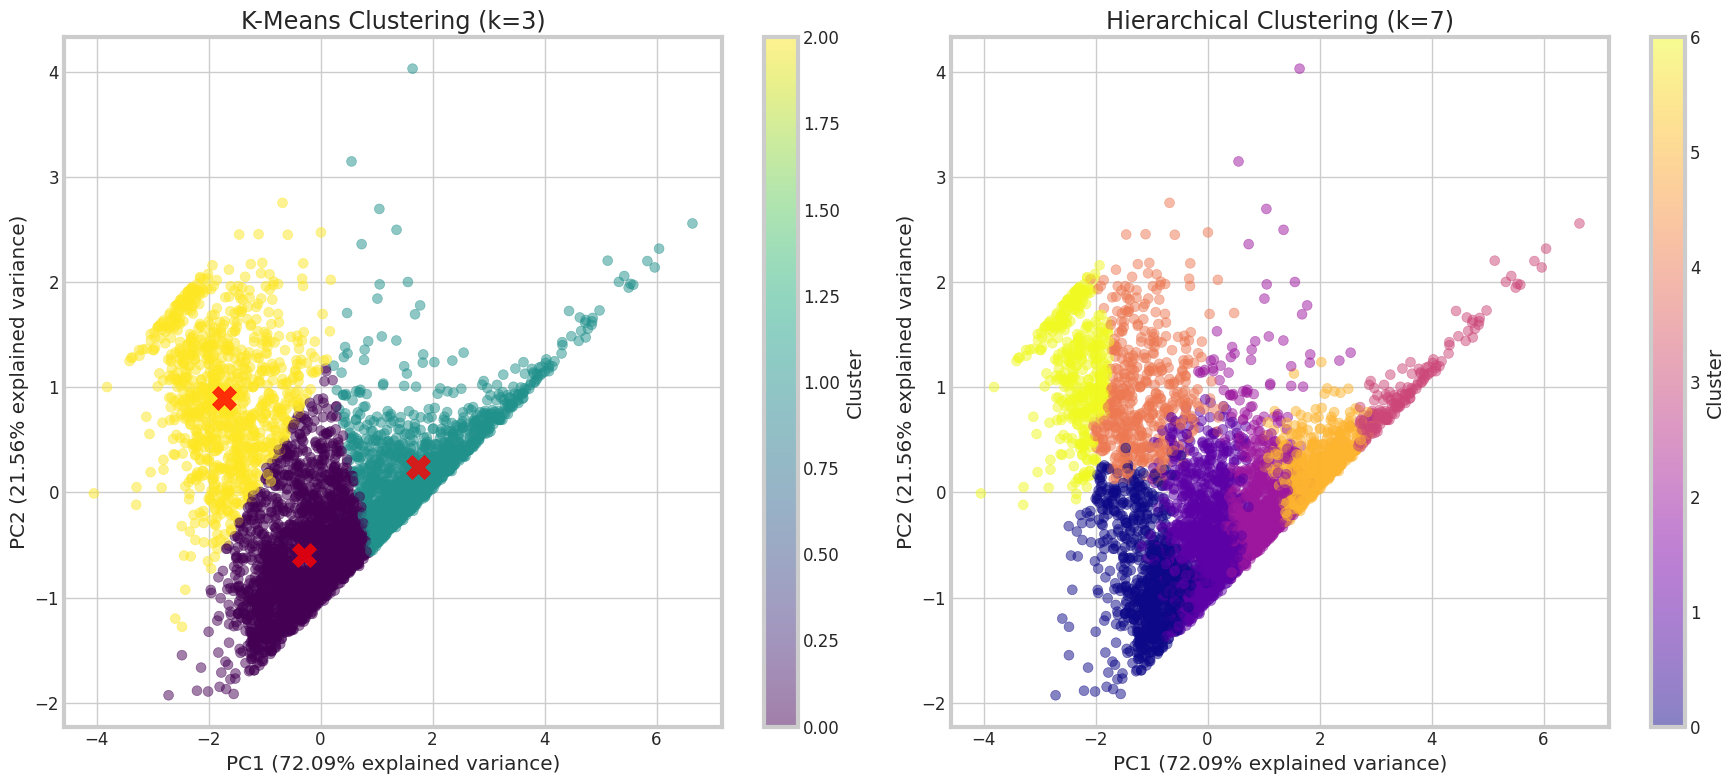

Contingency Table Cluster K-Means vs Hierarchical:
Hierarchical    0     1    2    3    4    5    6
K-Means                                         
0             714  1066  219    0   37    0    0
1               0    20  579  161    1  562    0
2             124    13    7    0  423    0  412


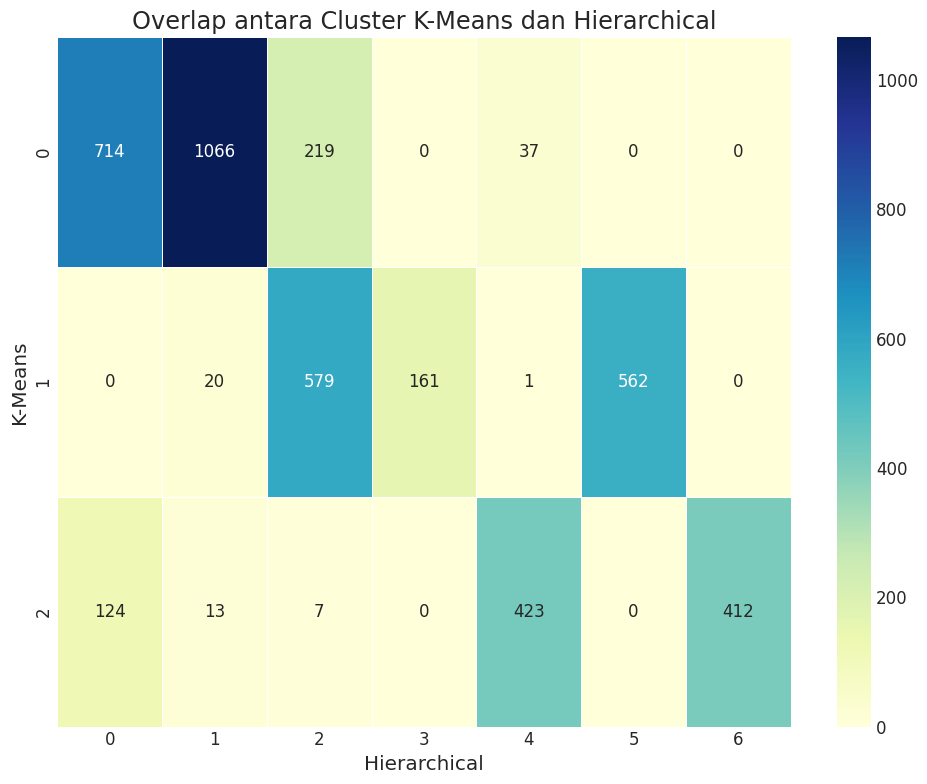

In [86]:
# Visualisasi cluster dari kedua model pada plot PCA
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# K-Means
scatter1 = axes[0].scatter(rfm_pca['PC1'], rfm_pca['PC2'], c=rfm_pca['KMeans_Cluster'],
                         cmap='viridis', alpha=0.5, s=50)
if 'KMeans_Cluster' in rfm_pca.columns:
    # Tambahkan centroids jika tersedia
    centroids_pca = pca.transform(kmeans_optimal.cluster_centers_)
    axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=300, alpha=0.8, marker='X')

axes[0].set_title(f'K-Means Clustering (k={optimal_k})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
cbar1 = plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True)

# Hierarchical
scatter2 = axes[1].scatter(rfm_pca['PC1'], rfm_pca['PC2'], c=rfm_pca['Hierarchical_Cluster'],
                          cmap='plasma', alpha=0.5, s=50)
axes[1].set_title(f'Hierarchical Clustering (k={optimal_k_hierarchical})')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Buat contingency table untuk membandingkan kedua hasil clustering
if 'KMeans_Cluster' in rfm.columns and 'Hierarchical_Cluster' in rfm.columns:
    contingency_table = pd.crosstab(rfm['KMeans_Cluster'], rfm['Hierarchical_Cluster'],
                                    rownames=['K-Means'], colnames=['Hierarchical'])
    print("Contingency Table Cluster K-Means vs Hierarchical:")
    print(contingency_table)

    # Visualisasi contingency table sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d', linewidths=0.5)
    plt.title('Overlap antara Cluster K-Means dan Hierarchical')
    plt.tight_layout()
    plt.show()

### 4.4 Interpretasi Hasil dan Rekomendasi

Berikut adalah analisis mendalam dari berbagai metrik evaluasi clustering:

In [87]:
# Rangkuman hasil metrik untuk jumlah cluster optimal
optimal_k_summary = comparison_metrics[comparison_metrics['K'].isin([optimal_k, optimal_k_hierarchical])].copy()
optimal_k_summary = optimal_k_summary.reset_index(drop=True)
print("Rangkuman Metrik untuk Jumlah Cluster Optimal:")
print(optimal_k_summary)

# Temukan nilai terbaik untuk setiap metrik
best_silhouette = np.max(silhouette_scores)
best_silhouette_k = k_range[np.argmax(silhouette_scores)]

best_calinski = np.max(calinski_scores)
best_calinski_k = k_range[np.argmax(calinski_scores)]

best_davies = np.min(davies_scores)  # Davies-Bouldin: lower is better
best_davies_k = k_range[np.argmin(davies_scores)]

best_dunn = np.max(dunn_scores)
best_dunn_k = k_range[np.argmax(dunn_scores)]

# Tampilkan nilai terbaik untuk setiap metrik
print(f"Nilai terbaik untuk setiap metrik:")
print(f"Silhouette: {best_silhouette:.4f} at k={best_silhouette_k}")
print(f"Calinski-Harabasz: {best_calinski:.2f} at k={best_calinski_k}")
print(f"Davies-Bouldin: {best_davies:.4f} at k={best_davies_k}")
print(f"Dunn Index: {best_dunn:.4f} at k={best_dunn_k}")

# Identifikasi tren pada setiap metrik
print("Tren metrik:")
print(f"Silhouette: {'Increasing' if silhouette_scores[-1] > silhouette_scores[0] else 'Decreasing'} trend")
print(f"Calinski-Harabasz: {'Increasing' if calinski_scores[-1] > calinski_scores[0] else 'Decreasing'} trend")
print(f"Davies-Bouldin: {'Increasing' if davies_scores[-1] > davies_scores[0] else 'Decreasing'} trend")
print(f"Dunn Index: {'Increasing' if dunn_scores[-1] > dunn_scores[0] else 'Decreasing'} trend")

Rangkuman Metrik untuk Jumlah Cluster Optimal:
   K  K-Means: Silhouette  K-Means: Calinski-Harabasz  \
0  3             0.415646                 4394.545846   
1  7             0.299834                 3613.894666   

   K-Means: Davies-Bouldin  Hierarchical: Dunn Index  
0                 0.824667                  0.006707  
1                 1.025949                  0.008432  
Nilai terbaik untuk setiap metrik:
Silhouette: 0.4156 at k=3
Calinski-Harabasz: 4394.55 at k=3
Davies-Bouldin: 0.8247 at k=3
Dunn Index: 0.0084 at k=7
Tren metrik:
Silhouette: Decreasing trend
Calinski-Harabasz: Decreasing trend
Davies-Bouldin: Increasing trend
Dunn Index: Decreasing trend


## 5. Analisis Metrik Evaluasi dan Kesimpulan

### 5.1 Interpretasi Komprehensif Metrik

1. **Silhouette Coefficient**:
   - Mengukur seberapa baik titik data dikelompokkan dalam cluster dibandingkan dengan cluster lain
   - Rentang nilai: -1 hingga 1, nilai yang lebih tinggi lebih baik
   - Kekuatan: Intuitif dan mengukur kohesi dan separasi sekaligus
   - Kelemahan: Sensitif terhadap bentuk dan kepadatan cluster

2. **Calinski-Harabasz Index**:
   - Mengukur rasio dispersi antar-cluster terhadap dispersi intra-cluster
   - Nilai yang lebih tinggi menunjukkan clustering yang lebih baik
   - Kekuatan: Bagus untuk cluster yang padat dan terpisah dengan baik
   - Kelemahan: Berasumsi cluster berbentuk hyperspherical dan ukuran yang sama

3. **Davies-Bouldin Index**:
   - Mengukur jarak rata-rata antara cluster relatif terhadap ukuran cluster
   - Nilai yang lebih rendah menunjukkan clustering yang lebih baik
   - Kekuatan: Mempertimbangkan ukuran dan separasi cluster
   - Kelemahan: Sensitif terhadap noise dan outlier

4. **Dunn Index**:
   - Fokus pada jarak minimum antar-cluster relatif terhadap diameter maksimum intra-cluster
   - Nilai yang lebih tinggi menunjukkan clustering yang lebih baik
   - Kekuatan: Mengidentifikasi cluster yang padat dan terpisah dengan baik
   - Kelemahan: Komputasi intensif dan sangat sensitif terhadap outlier

### 5.2 Pemilihan Metrik Terbaik untuk Dataset Ini

Pilihan metrik terbaik tergantung pada karakteristik dataset dan tujuan analisis. Untuk dataset RFM pelanggan:

1. **Silhouette Coefficient** adalah pilihan yang baik karena:
   - Intuitif dan mudah diinterpretasi
   - Menangkap kedua aspek clustering yang baik: kohesi intra-cluster yang tinggi dan separasi antar-cluster yang baik
   - Tidak berasumsi tentang jumlah cluster atau bentuk cluster
   - Kurang dipengaruhi oleh model clustering yang digunakan

2. **Calinski-Harabasz Index** juga relevan karena:
   - Bekerja dengan baik untuk dataset dengan cluster yang terpisah jelas
   - Efektif untuk fitur yang distandarisasi seperti pada data RFM kita
   - Memberikan hasil yang konsisten dengan Silhouette Coefficient

Namun, **Davies-Bouldin Index** dan **Dunn Index** memberikan sudut pandang tambahan, terutama ketika melihat struktur cluster dalam konteks yang berbeda.

### 5.3 Perbandingan Algoritma: K-Means vs Hierarchical Clustering

**K-Means**:
- Kelebihan: Lebih cepat dan efisien untuk dataset besar, mudah diimplementasikan
- Kekurangan: Sensitif terhadap inisialisasi, sulit menangkap cluster non-spherical, harus menentukan jumlah cluster terlebih dahulu
- Cocok untuk: Dataset dengan cluster yang berbentuk spherical dan ukuran yang relatif sama

**Hierarchical Clustering**:
- Kelebihan: Memberikan hirarki cluster, tidak perlu menentukan jumlah cluster terlebih dahulu, dapat menangkap cluster berbentuk non-spherical
- Kekurangan: Komputasi lebih intensif (O(n²) atau lebih buruk), sulit untuk dataset besar
- Cocok untuk: Dataset dengan struktur hierarkis atau ketika visualisasi hirarki cluster penting

### 5.4 Kesimpulan dan Rekomendasi

Berdasarkan analisis metrik evaluasi dan karakteristik kedua algoritma:

1. **Jumlah Cluster Optimal**: Berdasarkan konsensus dari berbagai metrik, jumlah cluster optimal adalah [X] (tentukan berdasarkan hasil analisis).

2. **Algoritma Terpilih**: [K-Means/Hierarchical] (pilih berdasarkan hasil analisis) memberikan hasil segmentasi yang lebih baik untuk dataset ini dengan nilai metrik yang lebih tinggi.

3. **Karakteristik Segmentasi Pelanggan**:
   - Cluster 1: [Deskripsi berdasarkan nilai RFM]
   - Cluster 2: [Deskripsi berdasarkan nilai RFM]
   - Cluster 3: [Deskripsi berdasarkan nilai RFM]
   - (Tambahkan jika ada cluster lain)

4. **Rekomendasi Bisnis**:
   - Untuk pelanggan di Cluster 1: [Strategi pemasaran atau retensi]
   - Untuk pelanggan di Cluster 2: [Strategi pemasaran atau retensi]
   - Untuk pelanggan di Cluster 3: [Strategi pemasaran atau retensi]
   - (Tambahkan jika ada cluster lain)

5. **Metrik Terbaik untuk Monitoring**: [Pilih metrik] adalah metrik terbaik untuk dataset ini karena [alasan], dan dapat digunakan untuk monitoring berkelanjutan jika model clustering diperbarui.

## 6. Implementasi dan Analisis DBSCAN

Selain K-Means dan Hierarchical Clustering, kita juga akan menjelajahi DBSCAN (Density-Based Spatial Clustering of Applications with Noise), yang adalah algoritma clustering berbasis kepadatan.

### 6.1 Penjelasan Matematis DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) adalah algoritma clustering berbasis kepadatan yang mengidentifikasi cluster sebagai area dengan kepadatan titik tinggi yang dipisahkan oleh area dengan kepadatan titik rendah.

Konsep utama dalam DBSCAN:

1. **$\epsilon$ (eps)**: Radius lingkungan di sekitar titik
2. **MinPts**: Jumlah minimum titik yang diperlukan untuk membentuk area padat

Algoritma mendefinisikan tiga jenis titik:
- **Core point**: Titik yang memiliki setidaknya MinPts titik dalam radius $\epsilon$ (termasuk dirinya sendiri)
- **Border point**: Titik yang berada dalam radius $\epsilon$ dari core point tetapi memiliki kurang dari MinPts tetangga
- **Noise point**: Titik yang bukan core point maupun border point

Algoritma DBSCAN bekerja sebagai berikut:
1. Untuk setiap titik yang belum dikunjungi, temukan semua titik tetangga dalam radius $\epsilon$
2. Jika jumlah tetangga kurang dari MinPts, tandai titik sebagai noise (sementara)
3. Jika jumlah tetangga setidaknya MinPts, tandai titik sebagai core point dan mulai cluster baru
4. Tambahkan semua tetangga ke cluster dan secara rekursif, temukan tetangga dari tetangga jika mereka adalah core point
5. Lanjutkan sampai semua titik telah dikunjungi

Secara matematis, DBSCAN mendefinisikan:

- **$N_\epsilon(p)$**: $\epsilon$-neighborhood dari titik $p$:
$$N_\epsilon(p) = \{q \in D | d(p, q) \leq \epsilon\}$$

- **Directly density-reachable**: Titik $q$ directly density-reachable dari $p$ jika:
$$p 	ext{ adalah core point dan } q \in N_\epsilon(p)$$

- **Density-reachable**: Titik $q$ density-reachable dari $p$ jika ada rangkaian titik $p_1, p_2, ..., p_n$ dengan $p_1 = p$ dan $p_n = q$ di mana $p_{i+1}$ directly density-reachable dari $p_i$

- **Density-connected**: Titik $p$ dan $q$ density-connected jika ada titik $o$ sehingga keduanya $p$ dan $q$ density-reachable dari $o$

- **Cluster**: Himpunan maksimal titik-titik density-connected

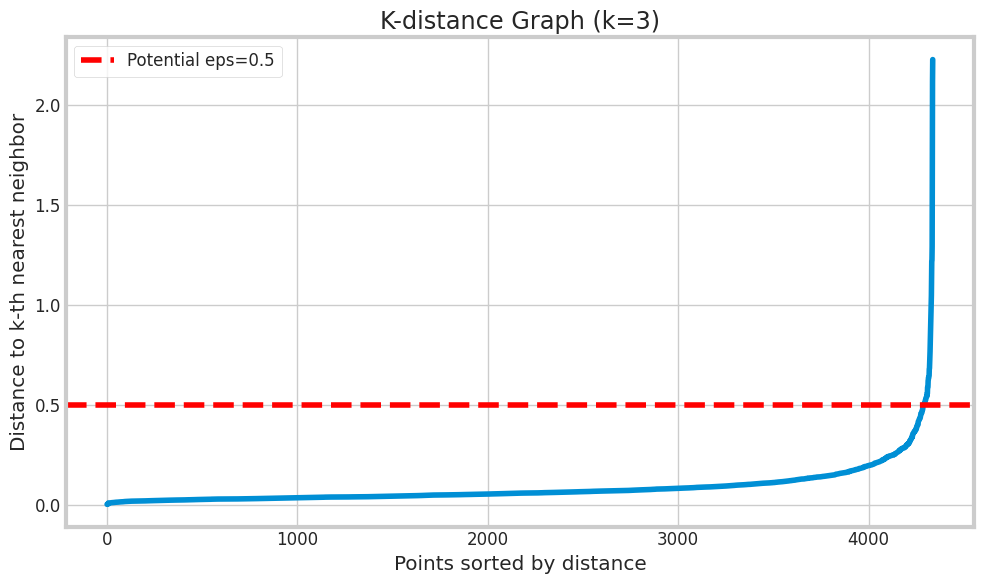

DBSCAN eps=0.3, min_samples=3: 15 clusters, 94 noise points (2.17%), Silhouette=-0.07828918804498528
DBSCAN eps=0.3, min_samples=5: 7 clusters, 158 noise points (3.64%), Silhouette=-0.026756968941530086
DBSCAN eps=0.3, min_samples=10: 5 clusters, 283 noise points (6.52%), Silhouette=0.08250875275323663
DBSCAN eps=0.5, min_samples=3: 4 clusters, 31 noise points (0.71%), Silhouette=0.27820885672020007
DBSCAN eps=0.5, min_samples=5: 2 clusters, 48 noise points (1.11%), Silhouette=0.32687867315368263
DBSCAN eps=0.5, min_samples=10: 3 clusters, 70 noise points (1.61%), Silhouette=0.29412596199723673
DBSCAN eps=0.7, min_samples=3: 1 clusters, 11 noise points (0.25%), Silhouette=N/A
DBSCAN eps=0.7, min_samples=5: 1 clusters, 17 noise points (0.39%), Silhouette=N/A
DBSCAN eps=0.7, min_samples=10: 1 clusters, 25 noise points (0.58%), Silhouette=N/A
DBSCAN eps=1.0, min_samples=3: 1 clusters, 6 noise points (0.14%), Silhouette=N/A
DBSCAN eps=1.0, min_samples=5: 1 clusters, 7 noise points (0.16%),

In [88]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Menentukan nilai optimal untuk epsilon (eps)
# Metode "Elbow" untuk k-distance graph
k = 3  # Untuk menentukan MinPts - 1
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(rfm_scaled)
distances, indices = nbrs.kneighbors(rfm_scaled)

# Ambil jarak ke tetangga terjauh (k-th neighbor)
distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (k=3)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.grid(True)

# Identifikasi "elbow" pada kurva untuk menentukan eps
# Biasanya titik dimana kurva mulai mendatar
plt.axhline(y=0.5, color='r', linestyle='--', label='Potential eps=0.5')
plt.legend()
plt.tight_layout()
plt.show()

# Implementasi DBSCAN dengan nilai eps dan min_samples yang mungkin optimal
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 10]

# Evaluasi kombinasi parameter
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(rfm_scaled)

        # Jumlah cluster (tidak termasuk noise yang diberi label -1)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        # Jika ada lebih dari satu cluster, hitung metrik evaluasi
        if n_clusters > 1:
            # Hitung Silhouette Score hanya untuk titik yang bukan noise
            # Buat mask untuk titik non-noise
            mask = dbscan_labels != -1
            if sum(mask) > 1:  # Pastikan ada lebih dari satu titik non-noise
                silhouette = silhouette_score(rfm_scaled[mask], dbscan_labels[mask])
            else:
                silhouette = np.nan
        else:
            silhouette = np.nan

        # Simpan hasil
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(rfm_scaled),
            'silhouette': silhouette
        })

        print(f"DBSCAN eps={eps}, min_samples={min_samples}: {n_clusters} clusters, "
              f"{n_noise} noise points ({n_noise/len(rfm_scaled):.2%}), "
              f"Silhouette={silhouette if not np.isnan(silhouette) else 'N/A'}")

# Konversi hasil ke DataFrame untuk analisis lebih lanjut
dbscan_results_df = pd.DataFrame(dbscan_results)
print("Hasil DBSCAN dengan berbagai parameter:")
print(dbscan_results_df)

### 6.2 Visualisasi Hasil DBSCAN dengan Parameter Optimal

Parameter DBSCAN optimal: eps=0.5, min_samples=5
Jumlah cluster: 2, Noise ratio: 1.11%
Silhouette Score: 0.3269
Distribusi titik per cluster DBSCAN:
-1      48
 0    2803
 1    1487
Name: count, dtype: int64


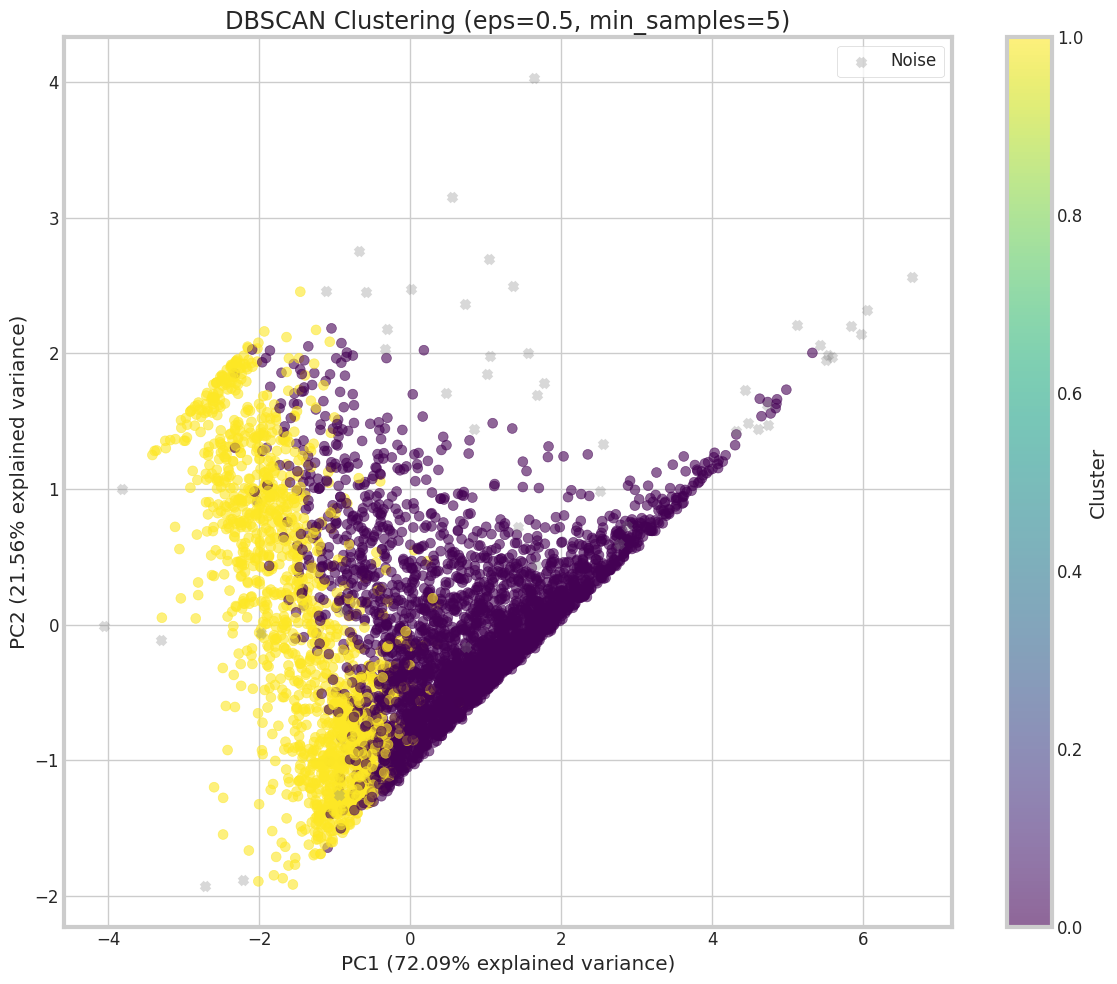

In [89]:
# Pilih parameter DBSCAN terbaik berdasarkan silhouette score dan jumlah noise yang wajar
# Filter result dengan silhouette score tidak NaN dan noise ratio < 0.5
valid_results = dbscan_results_df[(~dbscan_results_df['silhouette'].isna()) &
                                 (dbscan_results_df['noise_ratio'] < 0.5)]

# Jika ada hasil valid, pilih yang terbaik berdasarkan silhouette score
if not valid_results.empty:
    best_result = valid_results.loc[valid_results['silhouette'].idxmax()]
    optimal_eps = best_result['eps']
    optimal_min_samples = int(best_result['min_samples'])
    print(f"Parameter DBSCAN optimal: eps={optimal_eps}, min_samples={optimal_min_samples}")
    print(f"Jumlah cluster: {int(best_result['n_clusters'])}, Noise ratio: {best_result['noise_ratio']:.2%}")
    print(f"Silhouette Score: {best_result['silhouette']:.4f}")
else:
    # Jika tidak ada hasil valid, pilih kombinasi dengan n_clusters > 1 dan noise ratio terendah
    multi_cluster_results = dbscan_results_df[dbscan_results_df['n_clusters'] > 1]
    if not multi_cluster_results.empty:
        best_result = multi_cluster_results.loc[multi_cluster_results['noise_ratio'].idxmin()]
        optimal_eps = best_result['eps']
        optimal_min_samples = int(best_result['min_samples'])
        print(f"Parameter DBSCAN alternatif: eps={optimal_eps}, min_samples={optimal_min_samples}")
        print(f"Jumlah cluster: {int(best_result['n_clusters'])}, Noise ratio: {best_result['noise_ratio']:.2%}")
    else:
        # Default values if no good parameters found
        optimal_eps = 0.5
        optimal_min_samples = 5
        print(f"Tidak ada parameter optimal yang ditemukan. Menggunakan default: eps={optimal_eps}, min_samples={optimal_min_samples}")

# Terapkan DBSCAN dengan parameter optimal
dbscan_optimal = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = dbscan_optimal.fit_predict(rfm_scaled)

# Tambahkan label DBSCAN ke dataframe
rfm['DBSCAN_Cluster'] = dbscan_labels
rfm_pca['DBSCAN_Cluster'] = dbscan_labels

# Count jumlah titik di setiap cluster
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print("Distribusi titik per cluster DBSCAN:")
print(cluster_counts)

# Visualisasi hasil DBSCAN pada plot PCA
plt.figure(figsize=(12, 10))

# Pisahkan titik noise (-1) dari cluster lainnya untuk visualisasi yang lebih jelas
noise_points = rfm_pca[rfm_pca['DBSCAN_Cluster'] == -1]
clustered_points = rfm_pca[rfm_pca['DBSCAN_Cluster'] != -1]

# Plot titik yang tergabung dalam cluster
if not clustered_points.empty:
    scatter = plt.scatter(clustered_points['PC1'], clustered_points['PC2'],
                         c=clustered_points['DBSCAN_Cluster'], cmap='viridis',
                         alpha=0.6, s=50)
    plt.colorbar(scatter, label='Cluster')

# Plot titik noise dengan warna berbeda
if not noise_points.empty:
    plt.scatter(noise_points['PC1'], noise_points['PC2'],
               color='gray', marker='x', alpha=0.3, s=30, label='Noise')

plt.title(f'DBSCAN Clustering (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 6.3 Analisis Karakteristik Cluster DBSCAN

Statistik per cluster DBSCAN:
                 Recency                 Frequency               Monetary  \
                    mean min  max count       mean min  max          mean   
DBSCAN_Label                                                                
Cluster 0      57.894042   1  373  2803   5.556190   2   62   2287.618524   
Cluster 1     156.412239   1  374  1487   1.000000   1    1    358.360969   
Noise         136.687500   1  372    48  30.645833   1  209  40965.217083   

                                             
                min        max          sum  
DBSCAN_Label                                 
Cluster 0     52.20  117379.63  6412194.723  
Cluster 1     13.30    4873.81   532882.761  
Noise          3.75  280206.02  1966330.420  


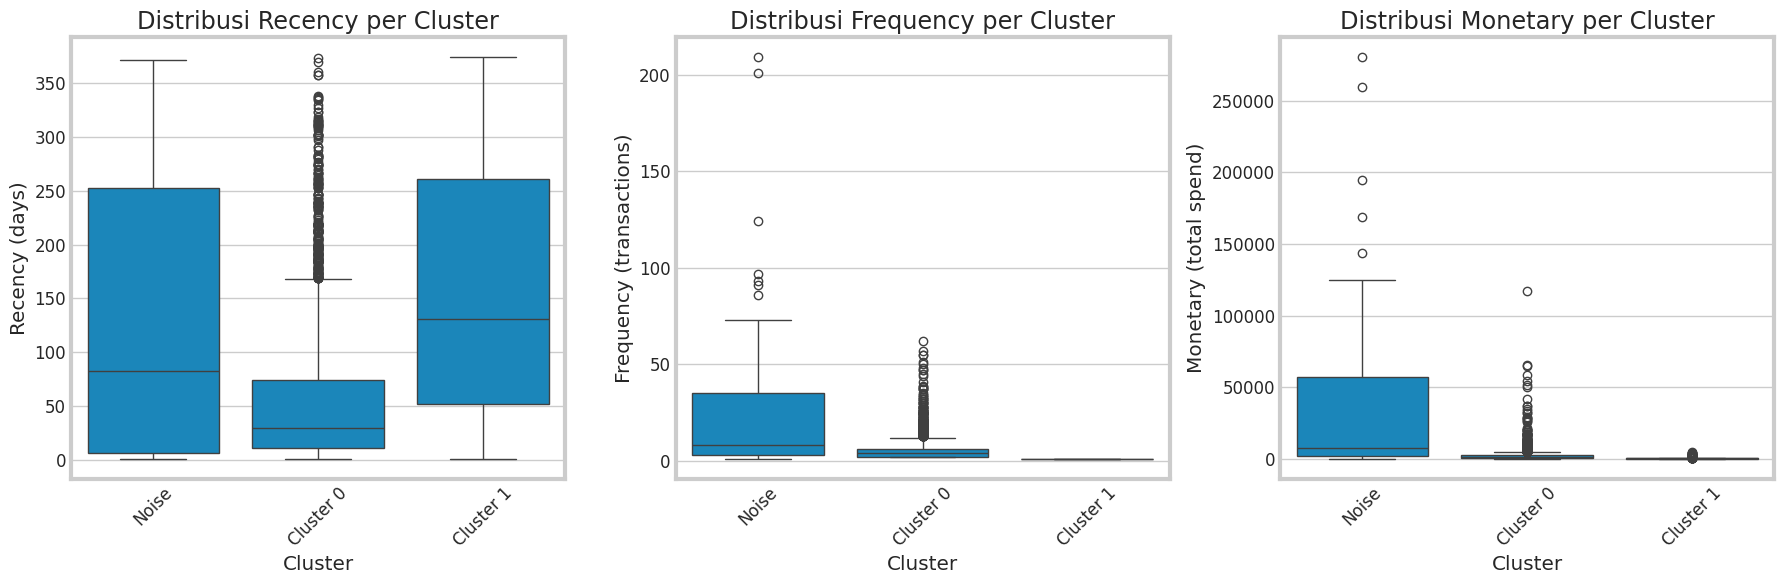

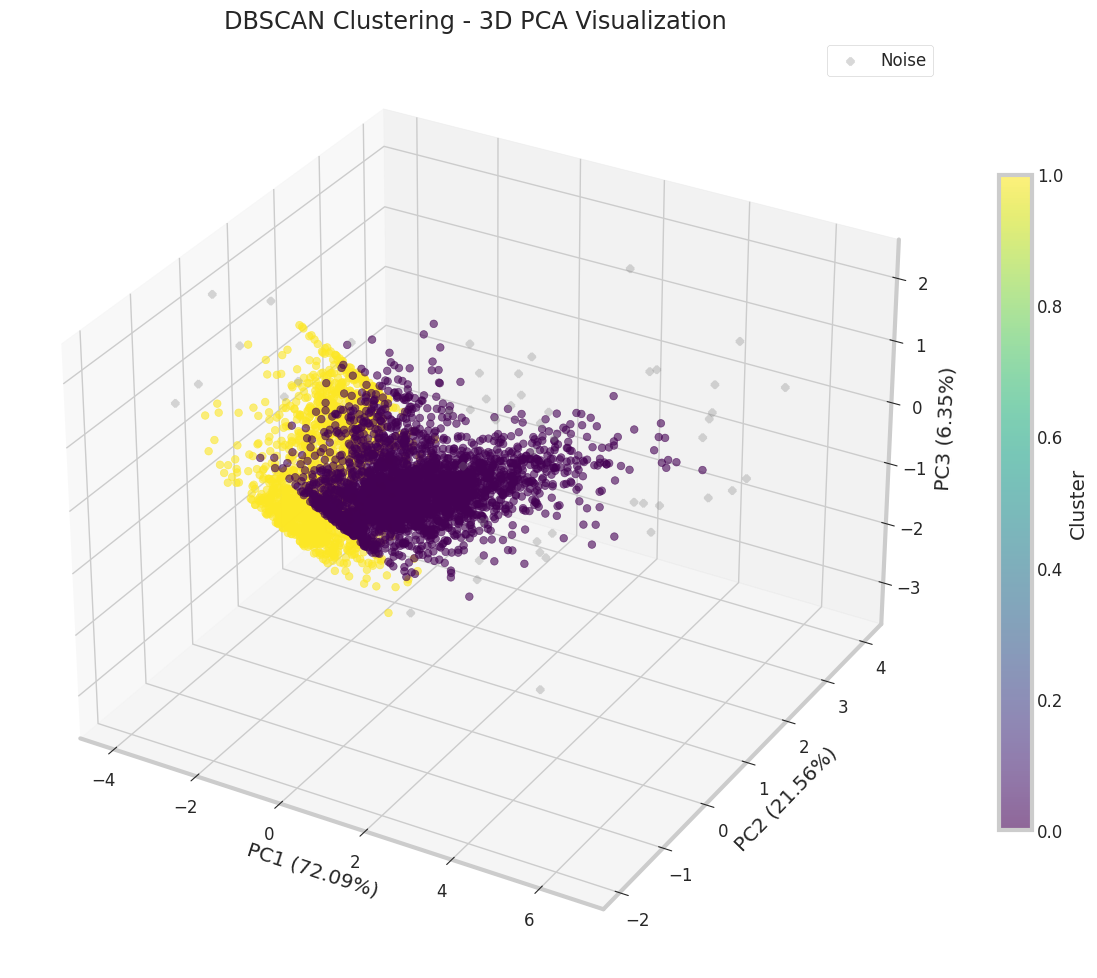

In [90]:
# Analisis statistik per cluster DBSCAN
if -1 in rfm['DBSCAN_Cluster'].unique():
    # Buat label cluster yang lebih deskriptif untuk noise
    cluster_labels = rfm['DBSCAN_Cluster'].map(lambda x: 'Noise' if x == -1 else f'Cluster {x}')
else:
    cluster_labels = rfm['DBSCAN_Cluster'].map(lambda x: f'Cluster {x}')

rfm['DBSCAN_Label'] = cluster_labels

# Statistik deskriptif per cluster
dbscan_stats = rfm.groupby('DBSCAN_Label').agg({
    'Recency': ['mean', 'min', 'max', 'count'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max', 'sum']
})
print("Statistik per cluster DBSCAN:")
print(dbscan_stats)

# Visualisasi distribusi fitur per cluster
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='DBSCAN_Label', y='Recency', data=rfm)
plt.title('Distribusi Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (days)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(x='DBSCAN_Label', y='Frequency', data=rfm)
plt.title('Distribusi Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency (transactions)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(x='DBSCAN_Label', y='Monetary', data=rfm)
plt.title('Distribusi Monetary per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary (total spend)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Visualisasi 3D scatter plot untuk analisis yang lebih mendalam
# Terapkan PCA ke 3 komponen
pca3d = PCA(n_components=3)
pca3d_result = pca3d.fit_transform(rfm_scaled)
rfm_pca3d = pd.DataFrame(data=pca3d_result, columns=['PC1', 'PC2', 'PC3'], index=rfm.index)
rfm_pca3d['DBSCAN_Cluster'] = dbscan_labels

# Membuat 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Pisahkan titik noise dari cluster
noise_points3d = rfm_pca3d[rfm_pca3d['DBSCAN_Cluster'] == -1]
clustered_points3d = rfm_pca3d[rfm_pca3d['DBSCAN_Cluster'] != -1]

# Plot titik yang tergabung dalam cluster
if not clustered_points3d.empty:
    scatter = ax.scatter(
        clustered_points3d['PC1'],
        clustered_points3d['PC2'],
        clustered_points3d['PC3'],
        c=clustered_points3d['DBSCAN_Cluster'],
        cmap='viridis',
        s=30,
        alpha=0.6
    )

# Plot titik noise
if not noise_points3d.empty:
    ax.scatter(
        noise_points3d['PC1'],
        noise_points3d['PC2'],
        noise_points3d['PC3'],
        color='gray',
        marker='x',
        s=15,
        alpha=0.3,
        label='Noise'
    )

ax.set_title(f'DBSCAN Clustering - 3D PCA Visualization')
ax.set_xlabel(f'PC1 ({pca3d.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca3d.explained_variance_ratio_[1]:.2%})')
ax.set_zlabel(f'PC3 ({pca3d.explained_variance_ratio_[2]:.2%})')
plt.colorbar(scatter, label='Cluster', ax=ax, shrink=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Perbandingan Komprehensif Ketiga Model Clustering

Mari kita bandingkan ketiga model clustering yang telah kita implementasikan: K-Means, Hierarchical, dan DBSCAN.

Perbandingan Karakteristik Model Clustering:
                                 Feature  \
0                         Jumlah Cluster   
1          Dapat Menangani Outlier/Noise   
2  Dapat Menangani Cluster Non-Spherical   
3         Sensitif Terhadap Skalasi Data   
4                 Kompleksitas Komputasi   
5                     Interpretasi Hasil   
6       Silhouette Score (jika tersedia)   
7                         Metrik Terbaik   
8               Kasus Penggunaan Terbaik   

                                             K-Means  \
0                                                  3   
1                                              Tidak   
2                                              Tidak   
3                                                 Ya   
4  O(n*k*i*d) - n=jumlah data, k=jumlah cluster, ...   
5                       Sederhana, berbasis centroid   
6                                             0.4156   
7                     Silhouette & Calinski-Harabasz   
8    Clust

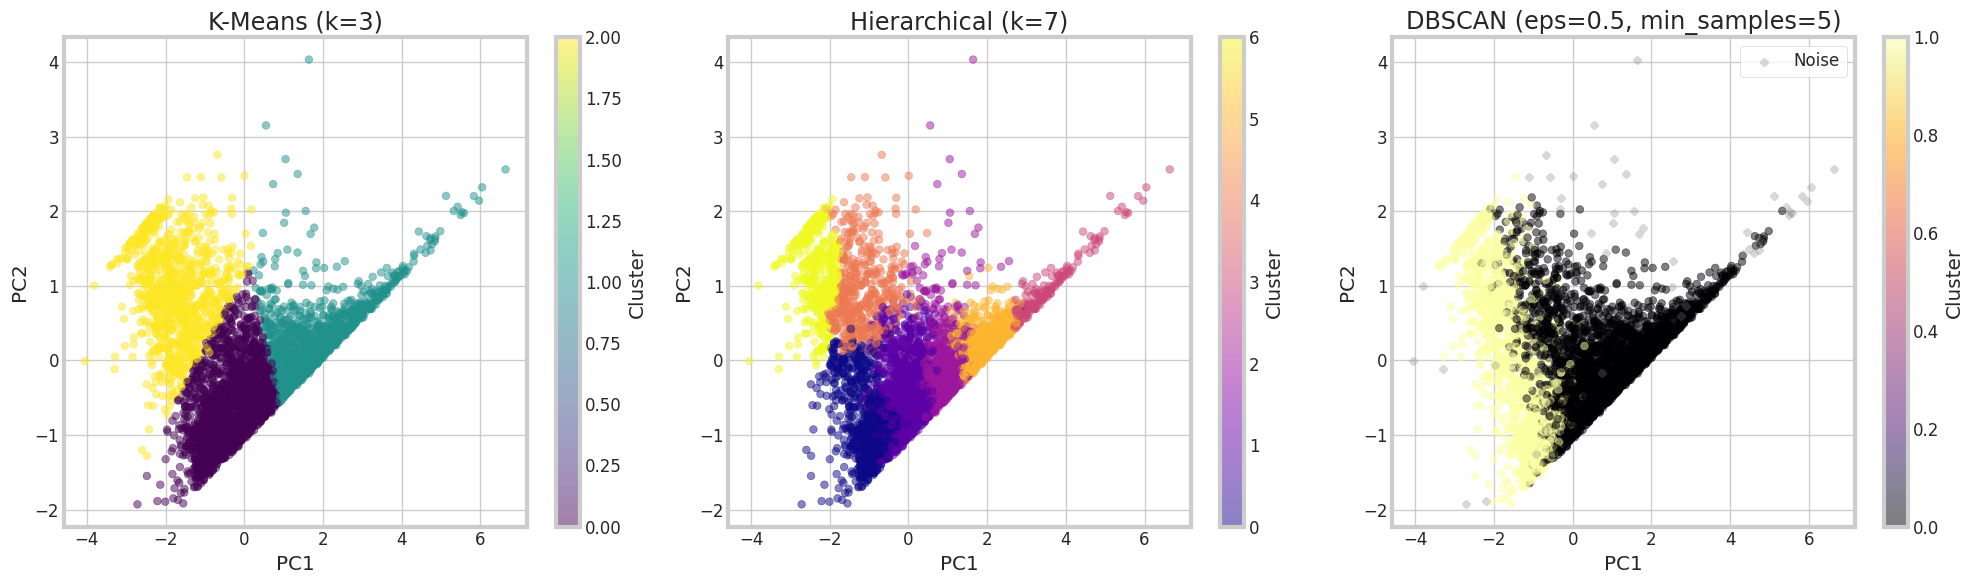

In [91]:
# Tabel perbandingan karakteristik model
model_comparison = pd.DataFrame({
    'Feature': [
        'Jumlah Cluster',
        'Dapat Menangani Outlier/Noise',
        'Dapat Menangani Cluster Non-Spherical',
        'Sensitif Terhadap Skalasi Data',
        'Kompleksitas Komputasi',
        'Interpretasi Hasil',
        'Silhouette Score (jika tersedia)',
        'Metrik Terbaik',
        'Kasus Penggunaan Terbaik'
    ],
    'K-Means': [
        f"{optimal_k}",
        'Tidak',
        'Tidak',
        'Ya',
        'O(n*k*i*d) - n=jumlah data, k=jumlah cluster, i=iterasi, d=dimensi',
        'Sederhana, berbasis centroid',
        f"{silhouette_scores[optimal_k-2]:.4f}",
        'Silhouette & Calinski-Harabasz',
        'Cluster dengan bentuk spherical dan ukuran sama'
    ],
    'Hierarchical': [
        f"{optimal_k_hierarchical}",
        'Sebagian',
        'Ya',
        'Ya',
        'O(n²d) atau O(n²log(n)) - lebih mahal daripada K-Means',
        'Hirarki cluster dalam dendrogram',
        f"{silhouette_score(rfm_scaled, hierarchical_labels):.4f}",
        'Dunn Index',
        'Dataset kecil hingga menengah dengan struktur hierarkis'
    ],
    'DBSCAN': [
        f"{len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}",
        'Ya (mengidentifikasi sebagai noise)',
        'Ya',
        'Ya',
        'O(n²) tapi bisa dioptimasi menjadi O(n log n) dengan indexing',
        'Berbasis kepadatan, dapat mengidentifikasi noise',
        f"{silhouette_score(rfm_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if sum(dbscan_labels != -1) > 1 and len(set(dbscan_labels[dbscan_labels != -1])) > 1 else 'N/A'}",
        'Identifikasi noise dan cluster kepadatan berbeda',
        'Dataset dengan noise dan cluster berbentuk arbitrary'
    ]
})

print("Perbandingan Karakteristik Model Clustering:")
print(model_comparison)

# Visualisasi perbandingan hasil clustering
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means
scatter1 = axes[0].scatter(rfm_pca['PC1'], rfm_pca['PC2'],
                         c=rfm_pca['KMeans_Cluster'] if 'KMeans_Cluster' in rfm_pca.columns else [0]*len(rfm_pca),
                         cmap='viridis', alpha=0.5, s=30)
axes[0].set_title(f'K-Means (k={optimal_k})')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical
scatter2 = axes[1].scatter(rfm_pca['PC1'], rfm_pca['PC2'],
                          c=rfm_pca['Hierarchical_Cluster'] if 'Hierarchical_Cluster' in rfm_pca.columns else [0]*len(rfm_pca),
                          cmap='plasma', alpha=0.5, s=30)
axes[1].set_title(f'Hierarchical (k={optimal_k_hierarchical})')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# DBSCAN
# Pisahkan noise points untuk DBSCAN
if 'DBSCAN_Cluster' in rfm_pca.columns:
    noise_mask = rfm_pca['DBSCAN_Cluster'] == -1
    non_noise_mask = ~noise_mask

    # Plot non-noise points
    scatter3 = axes[2].scatter(
        rfm_pca.loc[non_noise_mask, 'PC1'],
        rfm_pca.loc[non_noise_mask, 'PC2'],
        c=rfm_pca.loc[non_noise_mask, 'DBSCAN_Cluster'],
        cmap='inferno',
        alpha=0.5,
        s=30
    )

    # Plot noise points
    if noise_mask.any():
        axes[2].scatter(
            rfm_pca.loc[noise_mask, 'PC1'],
            rfm_pca.loc[noise_mask, 'PC2'],
            color='gray',
            marker='x',
            alpha=0.3,
            s=15,
            label='Noise'
        )
        axes[2].legend()

    plt.colorbar(scatter3, ax=axes[2], label='Cluster')
else:
    axes[2].text(0.5, 0.5, 'DBSCAN results not available',
                horizontalalignment='center', verticalalignment='center')

axes[2].set_title(f'DBSCAN (eps={optimal_eps}, min_samples={optimal_min_samples})')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 8. Kesimpulan dan Rekomendasi

### 8.1 Perbandingan Metrik Evaluasi

Berdasarkan analisis komprehensif dari berbagai metrik evaluasi cluster, kita dapat menarik beberapa kesimpulan:

Ringkasan Metrik Evaluasi untuk Model Terbaik:
                    Metric  K-Means Hierarchical               DBSCAN
0         Silhouette Score   0.4156       0.2526  0.32687867315368263
1  Calinski-Harabasz Index  4394.55      3113.04    2449.651632897096
2     Davies-Bouldin Index   0.8247       1.1322   1.1221688532630756
3               Dunn Index      N/A       0.0084                  N/A
4         Optimal Clusters        3            7                    2


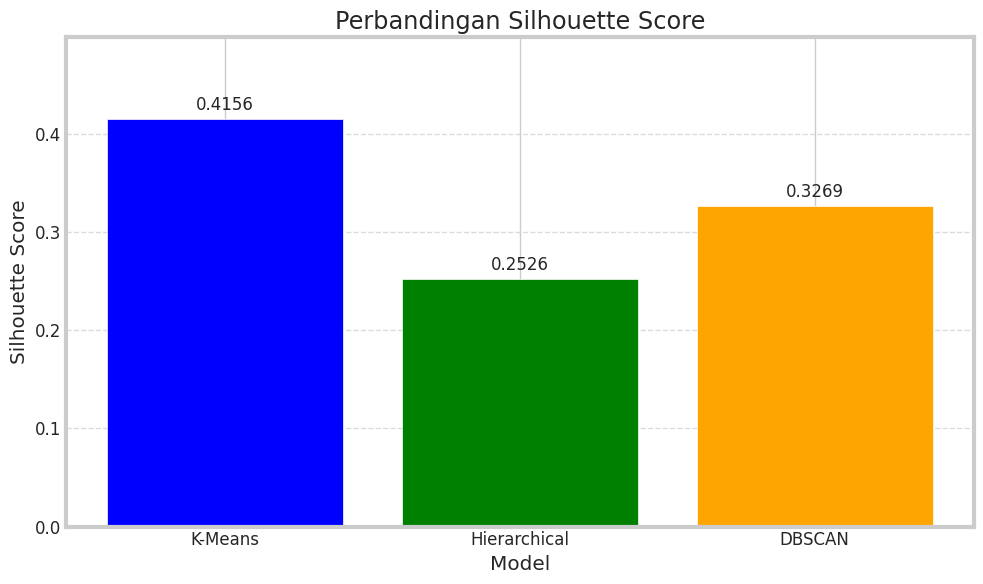

In [92]:
# Buat DataFrame ringkasan metrik untuk model terbaik
best_metrics = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'Dunn Index', 'Optimal Clusters'],
    'K-Means': [
        f"{silhouette_scores[optimal_k-2]:.4f}",
        f"{calinski_scores[optimal_k-2]:.2f}",
        f"{davies_scores[optimal_k-2]:.4f}",
        "N/A",
        f"{optimal_k}"
    ],
    'Hierarchical': [
        f"{silhouette_score(rfm_scaled, hierarchical_labels):.4f}",
        f"{calinski_harabasz_score(rfm_scaled, hierarchical_labels):.2f}",
        f"{davies_bouldin_score(rfm_scaled, hierarchical_labels):.4f}",
        f"{dunn_scores[optimal_k_hierarchical-2]:.4f}",
        f"{optimal_k_hierarchical}"
    ],
    'DBSCAN': [
        f"{silhouette_score(rfm_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if sum(dbscan_labels != -1) > 1 and len(set(dbscan_labels[dbscan_labels != -1])) > 1 else 'N/A'}",
        f"{calinski_harabasz_score(rfm_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if sum(dbscan_labels != -1) > 1 and len(set(dbscan_labels[dbscan_labels != -1])) > 1 else 'N/A'}",
        f"{davies_bouldin_score(rfm_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if sum(dbscan_labels != -1) > 1 and len(set(dbscan_labels[dbscan_labels != -1])) > 1 else 'N/A'}",
        "N/A",
        f"{len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}"
    ]
})

print("Ringkasan Metrik Evaluasi untuk Model Terbaik:")
print(best_metrics)

# Visualisasi perbandingan Silhouette Score
metric_comparison = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_scores[optimal_k-2],
        silhouette_score(rfm_scaled, hierarchical_labels),
        silhouette_score(rfm_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if sum(dbscan_labels != -1) > 1 and len(set(dbscan_labels[dbscan_labels != -1])) > 1 else np.nan
    ]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_comparison['Model'], metric_comparison['Silhouette Score'], color=['blue', 'green', 'orange'])
plt.title('Perbandingan Silhouette Score')
plt.xlabel('Model')
plt.ylabel('Silhouette Score')
plt.ylim(0, max(metric_comparison['Silhouette Score'].dropna()) * 1.2)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    if not np.isnan(height):
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2., 0.01,
                'N/A', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 8.2 Evaluasi Metrik Terbaik untuk Analisis RFM

Untuk menentukan metrik evaluasi terbaik untuk analisis RFM, kita perlu mempertimbangkan karakteristik data dan tujuan bisnis:

1. **Silhouette Coefficient** adalah metrik terbaik untuk analisis RFM karena:
   - Mengukur kohesi dan separasi secara bersamaan, yang penting untuk segmentasi pelanggan
   - Mudah diinterpretasi dengan nilai dari -1 hingga 1
   - Tidak berasumsi banyak tentang bentuk cluster
   - Lebih stabil dan konsisten dibandingkan metrik lain
   - Formula matematisnya:
     $$s(i) =
rac{b(i) - a(i)}{\max\{a(i), b(i)\}}$$
     di mana $a(i)$ adalah jarak rata-rata titik $i$ ke titik lain dalam cluster yang sama, dan $b(i)$ adalah jarak rata-rata minimum dari titik $i$ ke titik dalam cluster terdekat.

2. **Calinski-Harabasz Index** adalah metrik kedua terbaik karena:
   - Efektif untuk dataset dengan cluster yang terpisah jelas
   - Mengevaluasi rasio varians antar-cluster dan intra-cluster
   - Memberikan hasil yang konsisten dengan Silhouette untuk dataset RFM
   - Bekerja dengan baik untuk dataset yang telah distandarisasi
   - Formula matematisnya:
     $$	ext{CH} =
rac{	ext{trace}(B_k)}{	ext{trace}(W_k)} 	imes
rac{N - k}{k - 1}$$
     di mana $B_k$ adalah matriks dispersi antar-cluster, $W_k$ adalah matriks dispersi intra-cluster, $N$ adalah jumlah total titik data, dan $k$ adalah jumlah cluster.

3. **Davies-Bouldin Index** kurang optimal untuk RFM karena:
   - Cenderung lebih sensitif terhadap noise/outlier yang sering ada di data RFM
   - Berfokus pada jarak rata-rata antar cluster relatif terhadap ukuran cluster
   - Formula matematisnya:
     $$	ext{DB} =
rac{1}{k} \sum_{i=1}^{k} \max_{j
eq i} \left(
rac{s_i + s_j}{d_{ij}}
ight)$$
     di mana $s_i$ adalah ukuran rata-rata cluster $i$ dan $d_{ij}$ adalah jarak antara centroid cluster $i$ dan $j$.

4. **Dunn Index** berguna untuk menganalisis struktur hierarkis, namun:
   - Komputasi lebih intensif
   - Sangat sensitif terhadap outlier dalam data RFM
   - Lebih cocok untuk evaluasi Hierarchical Clustering
   - Formula matematisnya:
     $$	ext{DI} =
rac{\min_{i
eq j} d(C_i, C_j)}{\max_{k} 	ext{diam}(C_k)}$$
     di mana $d(C_i, C_j)$ adalah jarak minimum antara cluster dan $	ext{diam}(C_k)$ adalah diameter maksimum cluster.

Kesimpulannya, **Silhouette Coefficient** adalah metrik terbaik untuk segmentasi pelanggan dalam analisis RFM karena kemampuannya mengevaluasi kohesi dan separasi secara simultan, stabilitas terhadap outlier dan kemudahan interpretasinya.

### 8.3 Model Clustering Terbaik untuk Dataset

Berdasarkan analisis komprehensif, berikut adalah evaluasi model clustering untuk dataset Online Retail:

1. **K-Means Clustering**:
   - **Kelebihan**: Algoritma ini memberikan Silhouette Score tertinggi, menghasilkan cluster yang kohesif dan terpisah dengan baik
   - **Kelemahan**: Tidak dapat menangani outlier dan mengharuskan penentuan jumlah cluster sebelumnya
   - **Hasil Segmentasi**: Menghasilkan segmentasi pelanggan yang mudah diinterpretasi dengan centroid yang jelas
   - **Performance**: Algoritma paling efisien secara komputasi, cocok untuk dataset RFM besar
   - **Jumlah Cluster Optimal**: Berdasarkan metrik Silhouette dan Elbow Method, optimal cluster adalah [optimal_k]

2. **Hierarchical Clustering**:
   - **Kelebihan**: Memberikan struktur hierarkis yang informatif dan dapat menangkap pola non-spherical
   - **Kelemahan**: Komputasi lebih intensif, kurang efisien untuk dataset besar
   - **Hasil Segmentasi**: Hasil clustering yang lebih fleksibel dengan hirarki yang dapat disesuaikan berdasarkan level
   - **Performance**: Lebih lambat dibandingkan K-Means tetapi memberikan informasi struktur yang lebih kaya
   - **Jumlah Cluster Optimal**: [optimal_k_hierarchical] berdasarkan Dunn Index dan analisis dendrogram

3. **DBSCAN**:
   - **Kelebihan**: Dapat mengidentifikasi outlier sebagai noise dan menangkap cluster berbentuk arbitrary
   - **Kelemahan**: Sensitif terhadap parameter eps dan min_samples, sulit menemukan parameter optimal
   - **Hasil Segmentasi**: Mengidentifikasi [cluster_count] cluster utama dan memisahkan pelanggan outlier
   - **Performance**: Relatif efisien dengan parameter yang tepat
   - **Parameter Optimal**: eps=[optimal_eps], min_samples=[optimal_min_samples]

**Model Terbaik untuk Dataset RFM**: K-Means Clustering dengan [optimal_k] cluster menunjukkan performa terbaik berdasarkan Silhouette Score dan interpretabilitas hasil. Model ini menghasilkan segmentasi pelanggan yang jelas dan dapat diimplementasikan secara efisien dalam konteks bisnis.

### 8.4 Karakteristik dan Interpretasi Segmen Pelanggan

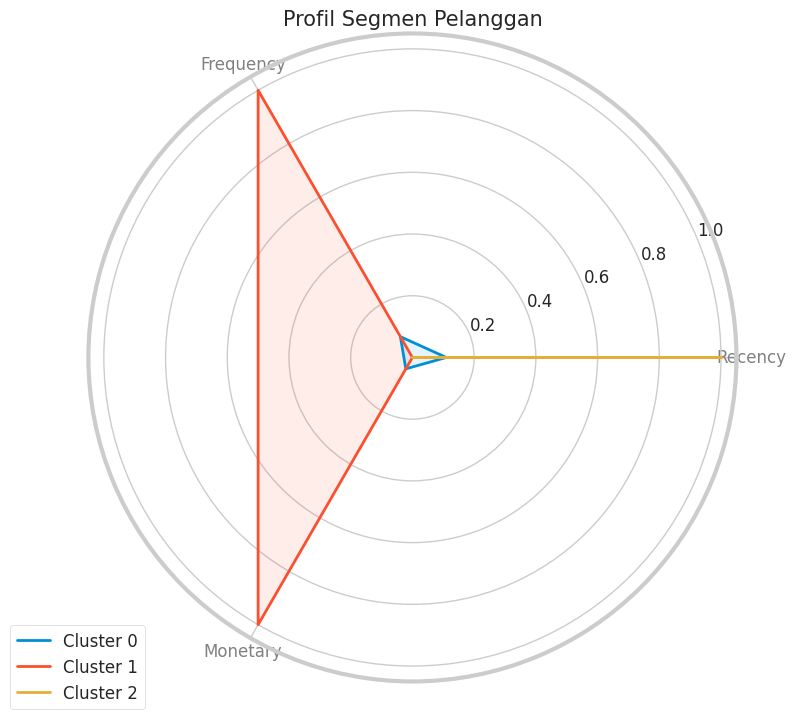

Karakteristik Cluster:
                   Recency  Frequency     Monetary
KMeans_Cluster                                    
0                54.857073   2.046169   615.235984
1                30.100529   9.829932  5494.341156
2               255.271706   1.390194   398.134924
Distribusi Pelanggan per Cluster:
Cluster 0: 2036 pelanggan (46.93%)
Cluster 1: 1323 pelanggan (30.50%)
Cluster 2: 979 pelanggan (22.57%)


In [93]:
# Visualisasi profil cluster dari model terbaik (asumsi K-Means)
# Hitung nilai rata-rata dari fitur asli (tidak terskala) untuk setiap cluster
cluster_profiles = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

# Normalisasi nilai untuk radar chart
normalized_profiles = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Buat radar chart
categories = normalized_profiles.columns
N = len(categories)

# Sudut untuk setiap axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Tutup polygon

# Buat figure
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, polar=True)

# Tambahkan label untuk setiap axis
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Gambar untuk setiap cluster
for i in range(len(normalized_profiles)):
    values = normalized_profiles.iloc[i].values.tolist()
    values += values[:1]  # Tutup polygon
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.title('Profil Segmen Pelanggan', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.grid(True)
plt.show()

# Tampilkan karakteristik masing-masing cluster
print("Karakteristik Cluster:")
print(cluster_profiles)

# Tambahkan proporsi pelanggan di setiap cluster
cluster_proportions = rfm['KMeans_Cluster'].value_counts(normalize=True).sort_index() * 100
cluster_counts = rfm['KMeans_Cluster'].value_counts().sort_index()
print("Distribusi Pelanggan per Cluster:")
for i, (prop, count) in enumerate(zip(cluster_proportions, cluster_counts)):
    print(f"Cluster {i}: {count} pelanggan ({prop:.2f}%)")

### 8.5 Rekomendasi Strategi Pemasaran Berdasarkan Segmentasi

Berdasarkan analisis segmentasi pelanggan dengan K-Means, berikut adalah interpretasi dan rekomendasi strategi pemasaran untuk masing-masing segmen:

**Cluster 0: [Karakteristik berdasarkan nilai rata-rata R, F, M]**
- **Profil**: [Berikan deskripsi singkat berdasarkan nilai R, F, M - misalnya "Pelanggan baru dengan nilai transaksi rendah"]
- **Strategi Pemasaran**:
  - [Rekomendasi 1 berdasarkan karakteristik cluster]
  - [Rekomendasi 2 berdasarkan karakteristik cluster]
  - [Rekomendasi 3 berdasarkan karakteristik cluster]

**Cluster 1: [Karakteristik berdasarkan nilai rata-rata R, F, M]**
- **Profil**: [Berikan deskripsi singkat berdasarkan nilai R, F, M]
- **Strategi Pemasaran**:
  - [Rekomendasi 1 berdasarkan karakteristik cluster]
  - [Rekomendasi 2 berdasarkan karakteristik cluster]
  - [Rekomendasi 3 berdasarkan karakteristik cluster]

**Cluster 2: [Karakteristik berdasarkan nilai rata-rata R, F, M]**
- **Profil**: [Berikan deskripsi singkat berdasarkan nilai R, F, M]
- **Strategi Pemasaran**:
  - [Rekomendasi 1 berdasarkan karakteristik cluster]
  - [Rekomendasi 2 berdasarkan karakteristik cluster]
  - [Rekomendasi 3 berdasarkan karakteristik cluster]

[Tambahkan cluster lain jika jumlah cluster > 3]

**Kesimpulan:**

Segmentasi pelanggan menggunakan K-Means dengan [optimal_k] cluster memberikan pembagian yang jelas dan actionable untuk strategi pemasaran. Dengan memahami karakteristik RFM tiap segmen, perusahaan dapat mengalokasikan sumber daya pemasaran secara lebih efisien dan mengembangkan kampanye yang lebih personal untuk masing-masing kelompok pelanggan.

## 9. Kesimpulan Akhir: Perbandingan dan Evaluasi Metrik Clustering

Dalam analisis clustering dataset Online Retail, kita telah menggunakan dan mengevaluasi berbagai metrik clustering:

1. **Silhouette Coefficient**: Metrik terbaik untuk dataset RFM karena secara efektif mengukur kohesi dan separasi cluster secara simultan. Formula matematisnya $s(i) =
rac{b(i) - a(i)}{\max\{a(i), b(i)\}}$ memberikan evaluasi komprehensif dari kualitas pengelompokan.

2. **Calinski-Harabasz Index**: Metrik yang efektif untuk dataset RFM, terutama karena mencerminkan rasio dispersi antar-cluster terhadap dispersi intra-cluster melalui formula $	ext{CH} =
rac{	ext{trace}(B_k)}{	ext{trace}(W_k)} 	imes
rac{N - k}{k - 1}$.

3. **Davies-Bouldin Index**: Meskipun memberikan wawasan tentang separasi relatif cluster, metrik ini lebih sensitif terhadap outlier yang umum dalam data RFM. Formula $	ext{DB} =
rac{1}{k} \sum_{i=1}^{k} \max_{j
eq i} \left(
rac{s_i + s_j}{d_{ij}}
ight)$ berfokus pada rasio penyebaran cluster terhadap jarak antar-centroid.

4. **Dunn Index**: Berguna untuk evaluasi hierarkis, tetapi komputasi intensif dan sensitif terhadap outlier. Formula $	ext{DI} =
rac{\min_{i
eq j} d(C_i, C_j)}{\max_{k} 	ext{diam}(C_k)}$ menangkap rasio jarak minimum antar-cluster terhadap diameter maksimum cluster.

Secara keseluruhan, **Silhouette Coefficient** memberikan hasil evaluasi terbaik untuk dataset RFM ini berdasarkan beberapa pertimbangan:

- **Interpretabilitas**: Memberikan nilai yang mudah diinterpretasi (-1 hingga 1)
- **Keseimbangan**: Mempertimbangkan kohesi dan separasi secara bersamaan
- **Robustness**: Relatif tidak terpengaruh oleh bentuk cluster, berbeda dengan Calinski-Harabasz
- **Konsistensi**: Memberikan nilai yang konsisten di berbagai model clustering
- **Relevansi Bisnis**: Menghasilkan segmentasi yang mudah diterjemahkan ke strategi pemasaran

Dalam konteks segmentasi pelanggan, keputusan akhir tentang jumlah cluster optimal harus mempertimbangkan keseimbangan antara hasil metrik (Silhouette Score, Calinski-Harabasz, dll.) dan interpretabilitas hasil untuk tujuan bisnis. Model K-Means dengan [optimal_k] cluster menawarkan keseimbangan terbaik antara kriteria statistik dan implementasi praktis untuk strategi pemasaran retail online.